#**Sistema Software de Aprendizaje Profundo basado en Detección de Objetos para Evaluar Cursogramas Automáticamente**

---

Sistema software que lleva a cabo la evaluación de un Cursograma (imagen versión Alumno) comparándolo contra un Cursograma de referencia (imagen versión Docente), mediante la aplicación de un modelo ResNet101 previamente entrenado con TF2 para detección la ubicación de los símbolos en ambas imágenes.
Nota: en esta versión ya no se usa el SequenceMatcher.

0) Preparar ambiente e instalar paquetes:

In [1]:
#@title Baja repositorio de modelos de TF
# clona el repositorio de modelos de TF si no está ya disponible
import os
import pathlib

if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 2397, done.
remote: Counting objects: 100% (2397/2397), done.
remote: Compressing objects: 100% (1985/1985), done.
remote: Total 2397 (delta 562), reused 1485 (delta 385), pack-reused 0
Receiving objects: 100% (2397/2397), 30.77 MiB | 38.00 MiB/s, done.
Resolving deltas: 100% (562/562), done.


In [2]:
#@title Instala el Object Detection API
# Nota: si dice que faltan librerías, ignorar (funciona bien igual) 
#       sino volverlo a ejecutar esta celda para que reinistale y entonces dice todo "successfully"
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Processing /content/models/research
  Created wheel for object-detection: filename=object_detection-0.1-cp36-none-any.whl size=1608567 sha256=2361c139aff001cddd564d2afb97621cb302a431eab0e98340578bdb58e7ecc6
  Stored in directory: /tmp/pip-ephem-wheel-cache-5k79mw10/wheels/94/49/4b/39b051683087a22ef7e80ec52152a27249d1a644ccf4e442ea
  Created wheel for avro-python3: filename=avro_python3-1.10.1-cp36-none-any.whl size=43734 sha256=6bcd3d0561b711aae63122a16f3561477706748df2c729484539e1635dafb775
  Stored in directory: /root/.cache/pip/wheels/65/fe/90/20d6d6d97223d80d20cb390be636619c536edab5658c12bdba
  Created wheel for hdfs: filename=hdfs-2.5.8-cp36-none-any.whl size=33213 sha256=55485949000695198a795877dcbdd77927a82046796c5fd67b4229f180e94a8c
  Stored in directory: /root/.cache/pip/wheels/fe/a7/05/23e3699975fc20f8a30e00ac1e515ab8c61168e982abe4ce70
  Created wheel for dill: filename=dill-0.3.1.1-cp36-none-any.whl size=78533 sha256=b2c0b7395bfeb2ac1e9d0e8d6529633f937494e807550fa1da100d44d8

ERROR: multiprocess 0.70.11.1 has requirement dill>=0.3.3, but you'll have dill 0.3.1.1 which is incompatible.
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.25.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: apache-beam 2.27.0 has requirement avro-python3!=1.9.2,<1.10.0,>=1.8.1, but you'll have avro-python3 1.10.1 which is incompatible.


In [3]:
#@title Baja e instala los paquetes de Tesseract-OCR 
!pip install pytesseract
!sudo apt install tesseract-ocr

  Created wheel for pytesseract: filename=pytesseract-0.3.7-py2.py3-none-any.whl size=13945 sha256=8adb3b36e24ef05b766c965b0a0d4f0d804ac5092b476078f110b3aad56a8034
  Stored in directory: /root/.cache/pip/wheels/81/20/7e/1dd0daad1575d5260916bb1e9781246430647adaef4b3ca3b3
Successfully built pytesseract
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 16 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http:/


1) Cargar librerías:

In [4]:
#@title Cargar las librerías necesarias

import os
import os.path
import sys
import numpy as np
import csv

import math 

from IPython.display import Image, display
from PIL import Image as ImPIL

import tensorflow as tf
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont

from google.colab import files
import time

import pytesseract

print ("Librerías cargadas")

Librerías cargadas


2) Montar el Drive:

In [5]:
#@title Montar el Drive y definir las configuración de las carpetas a usar

# monta Google Drive:
# Nota: la primera vez se debe confirmar el uso logueandose en "Google Drive File Stream" y obteniendo código de autentificación.
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

# configuración de directorios local en Google Drive
drive_path = '/content/gdrive/My Drive/GEMIS/objDetectionCursogramas'
data_dir_path = drive_path + '/Cursogramas'
model_drive_path = drive_path + '/TF_model'
evaluar_dir_path = data_dir_path + '/Para-Evaluar'

print("Configuración de archivos definida")

Mounted at /content/gdrive
Configuración de archivos definida


3) Cargar el modelo entrenado:

In [6]:
#@title Carga el Modelo de Object Detection ya entrenado y define funciones auxiliares
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

# carga el modelo exportado 
ModelObjDetEntrenado = model_drive_path + '/saved_model'
detection_model = tf.saved_model.load(str(ModelObjDetEntrenado))
print("\nModelo objDetector cargado: [", ModelObjDetEntrenado, "]: ", detection_model)

# archivo con lista de clases para reconocer 
labelMapFile = model_drive_path + '/label_map.pbtxt'

label_map = label_map_util.load_labelmap(labelMapFile)
categories = label_map_util.convert_label_map_to_categories(
    label_map,
    max_num_classes=label_map_util.get_max_label_map_index(label_map),
    use_display_name=True)
category_index = label_map_util.create_category_index(categories)
label_map_dict = label_map_util.get_label_map_dict(label_map, use_display_name=True)
print("\nDefinición de Clases cargada: [", labelMapFile, "]: ", len(category_index))

# función auxiliar para procesar la imagen con el modelo
def run_inference_for_single_image(model, image_np):   
    # fuerza conversión a array por las dudas
    image_np = np.asarray(image_np) 
    # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
    input_tensor = tf.convert_to_tensor(image_np)
    # The model expects a batch of images, so add an axis with `tf.newaxis`.
    input_tensor = input_tensor[tf.newaxis,...]

    # Run inference
    model_fn = model.signatures['serving_default']
    output_dict = model_fn(input_tensor)

    # All outputs are batches tensors.
    # Convert to numpy arrays, and take index [0] to remove the batch dimension.
    # We're only interested in the first num_detections.
    num_detections = int(output_dict.pop('num_detections'))
    output_dict = {key:value[0, :num_detections].numpy() 
                  for key,value in output_dict.items()}
    output_dict['num_detections'] = num_detections

    # detection_classes should be ints.
    output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
    
    # Handle models with masks:
    if 'detection_masks' in output_dict:
      # Reframe the the bbox mask to the image size.
      detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                output_dict['detection_masks'], output_dict['detection_boxes'],
                image.shape[0], image.shape[1])      
      detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                        tf.uint8)
      output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()
      
    return output_dict


# función auxiliar para mostrar resultados de procesar la imagen con el modelo
def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    line_thickness = 6,
                    min_score = 0.8):

    # genera una copia de la imagen
    image_np_with_annotations = image_np.copy()

    # en la copia marca los objetos detectados
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np_with_annotations,
        boxes,
        classes,
        scores,
        category_index,
        use_normalized_coordinates=True,
        max_boxes_to_draw=100,
        line_thickness=line_thickness,
        min_score_thresh=min_score,
        agnostic_mode=False)

    # muestra la copia de la imagen con los objetos detectados
    display(ImPIL.fromarray(image_np_with_annotations))  
    #print("-- objetos detectados: ", len(classes), "\n")  # siempre son 300

print("\nFunciones Auxiliares definidas.")


Modelo objDetector cargado: [ /content/gdrive/My Drive/GEMIS/objDetectionCursogramas/TF_model/saved_model ]:  <tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7f8cd72720f0>

Definición de Clases cargada: [ /content/gdrive/My Drive/GEMIS/objDetectionCursogramas/TF_model/label_map.pbtxt ]:  21

Funciones Auxiliares definidas.


In [7]:
#@title Carga la configuración de los símbolos del Cursograma


# carga la información de un archivo CSV
##model_drive_path
config_simbolos_file = model_drive_path + '/simbolos_config.csv'
with open(config_simbolos_file, mode='r') as csvfile:
    lineasCSV = list(csv.reader(csvfile))

# procesa el archivo CSV
auxList = []
for l in lineasCSV:
  # si no se debe ignorar las líneas de comentarios
  if l[0][0] != "#":     
      # carga la configuración del símbolo (aunque se ignore en la comparación)
      # campo clave: nombre - valores: [descripción, claseAgrupa, ignora?, tipoCambiarAreaY, tipoCambiarAreaX, OCRconfig, OCRcropDesp, OCRdescObs] 
      auxList.append( ( l[0], [ l[1], int(l[2]), (l[3]=="0"), int(l[4]), int(l[5]), int(l[6]), l[7], l[8] ] ) )

# genera dicccionario de la configuración de símbolos
config_simbolos = dict(auxList)

print(">Configuración de símbolos: ")
print("  cargada de [", config_simbolos_file, "] con ", len(auxList), " símbolos")
print("  valores: nombre + [descrip, [descripción, claseAgrupa, muestraEvaluación?, tipoCambiarAreaY, tipoCambiarAreaX, OCRconfig, OCRcropDesp, OCRdescObs] ] ")
print("  ", config_simbolos)

# constantes de posicion de configuraciones
config_posDescrip = 0
config_posClaseAgrupa = 1
config_posEvalua = 2
config_posTipoCambiarAreaY = 3
config_posTipoCambiarAreaX = 4
config_posOCRconfig = 5
config_posOCRcropDesp = 6
config_posOCRdescObs= 7

# función auxiliar que indica si se muestra la evaluación de un simbolo por su nombre
def muestraEvaluacion(simbolo):
  return config_simbolos[simbolo][config_posEvalua]


>Configuración de símbolos: 
  cargada de [ /content/gdrive/My Drive/GEMIS/objDetectionCursogramas/TF_model/simbolos_config.csv ] con  21  símbolos
  valores: nombre + [descrip, [descripción, claseAgrupa, muestraEvaluación?, tipoCambiarAreaY, tipoCambiarAreaX, OCRconfig, OCRcropDesp, OCRdescObs] ] 
   {'archivoDefinitivo': ['Archivo Definitivo', 22, True, 0, 0, -1, '-', '-'], 'archivoTransitorio': ['Archivo Transitorio', 22, True, 0, 0, -1, '-', '-'], 'conector_comienzoCorte': ['Conector de Comienzo de Corte', 22, True, 0, 0, -1, '15*15*30*30', 'con referencia'], 'conector_reanudacionCorte': ['Conector de Reanudacion de Corte', 22, True, 0, 0, -1, '30*30*15*15', 'con referencia'], 'control': ['Control', 22, True, 0, 0, -1, '13*13*13*13', 'con referencia'], 'decision': ['Decisión', 31, True, 1, 0, -1, '13*13*13*13', 'con referencia'], 'demora': ['Demora', 22, True, 0, 0, -1, '-', '-'], 'destruccion': ['Destrucción', 22, True, 0, 0, -1, '-', '-'], 'documento': ['Documento', 21, True, 0, 

4) Determina los parámetros para lleva a cabo la evaluación:

In [8]:
#@title Indique las imágenes a procesar: 
###{ run: "auto" }

# la imagen de referencia para evaluar
imagen_docente = 'curso_docente_02.png' #@param [ "curso_docente_01.png", "curso_docente_02.png", curso_docente_03.png", "curso_docente_04.png", "curso_docente_05.png" ] {allow-input: true}

# define las imágenes de alumnos a considerar
cargarAutomaticamenteImagenesAlumnos = True  #@param {type:"boolean"}
cargarAutomaticamenteImagenesAlumnosLimitarCant =  10#@param {type:"integer"}
lista_imagen_alumno = []
if cargarAutomaticamenteImagenesAlumnos:

  # lista auxiliar con las imágenes de alumnos a procesar 
  lista_imagen_alumno = [ fn for fn in os.listdir( evaluar_dir_path ) if fn.endswith('.png') or fn.endswith('.jpg') ]
  ## if (fn[0:7] == imagen_docente[0:7]) 
  lista_imagen_alumno = sorted(lista_imagen_alumno)  
  if cargarAutomaticamenteImagenesAlumnosLimitarCant > 0:
    lista_imagen_alumno = lista_imagen_alumno[:cargarAutomaticamenteImagenesAlumnosLimitarCant]
else:

  # la imagen a ser evaluada
  imagen_alumno = 'curso_alumno_03.png' #@param {type:"string"}
  lista_imagen_alumno.append( imagen_alumno )

print("Archivos a procesar: ")
print("   Docente: ", imagen_docente)
print("   Alumno: ", lista_imagen_alumno)

Archivos a procesar: 
   Docente:  curso_docente_02.png
   Alumno:  ['curso_alumno_01.png', 'curso_alumno_02.png', 'curso_alumno_03.png', 'curso_alumno_04.png', 'curso_alumno_05.png', 'curso_alumno_06.png', 'curso_alumno_07.png', 'curso_alumno_11.png', 'curso_alumno_12.png', 'curso_alumno_13.png']


In [14]:
#@title Defina parámetros a utilizar: { run: "auto" }

# define minima probabilidad a usar
minimaProbabilidadObjectosDetectados = 90
minProbObjDet = minimaProbabilidadObjectosDetectados / 100.

# define minima diferencia permitida para asignar objetos en áreas x
max_dif_permitida_areasX_simbolo = 10

# define parámetro Intersection over Union (IoU) 
## si calc_IoU(r1, r2) ≥ coefIoU, se considera que se detectó el objecto correctamente, es Verdadero Positivo (VP)
## si calc_IoU(r1, r2) < coefIoU, se considera que se detectó el objecto con error, es Falso Positivo (FP)
## -> valor recomendado por defecto: 0,5 
## pero se usa menos para mejorar los resultados
coefIoU = 0.3 

# parámetros para determinar si se puede ajustar
# la posición del objeto para asociar
max_dif_permitida_asociar_simbolo_eje = 5
max_dif_permitida_asociar_simbolo_var = 75
max_dif_permitida_asociar_mismoClase_difPos = 300

# indica los rangos de puntaje para asignar la 'Nota'
# debe quedar ordenado en orden decreciente
rango_notas = [ [100, "EXCELENTE"],
               [95, "MUY BIEN"],
               [85, "BIEN+"], 
               [75, "BIEN"], 
               [65, "BIEN-"], 
               [55, "REGULAR"],
               [50, "REGULAR-"],
               [0, "MAL"] ]
              
# tipos de letras para usar
im_font = ImageFont.truetype('/usr/share/fonts/truetype/liberation/LiberationMono-Bold.ttf', 14)
im_font_ref = ImageFont.truetype('/usr/share/fonts/truetype/liberation/LiberationMono-Bold.ttf', 12)
im_fontPequenia = ImageFont.truetype('/usr/share/fonts/truetype/liberation/LiberationMono-Regular.ttf', 10)

# define si muestra detalle o no
muestraDetalleDebug = False  #@param {type:"boolean"}
muestraDetalleObjDetectadosEnImagen = False  #@param {type:"boolean"}
muestraDetalleMetricasComparacion = False  #@param {type:"boolean"}
muestraDetalleComparacionEnImagen = "Todas" #@param [ "Solo con Error", "Todas"]

# define los colores a utilizar
# orden: OK, Faltan, Sobra, Diferentes, textoEncabezado
muestraDiferentesColoresComparacionEnImagen = True  #@param {type:"boolean"}
if muestraDiferentesColoresComparacionEnImagen:
  lista_colores_comparacion = [ (0,255,0), (255,0,0), (150,0,150), (255,75,0), (111,0,0) ]
else:
  lista_colores_comparacion = [ (0,255,0), (255,0,0), (255,0,0), (255,0,0), (111,0,0)]

# otros parámetros para mostrar correcciones
darkenColorFactorPorc = 25
grosorLineaBoxCorrecciones = 3

# define si se muestra la posición que le correspondeería 
# al objeto Docente en la imagen Alumno (para probar solamente)
muestraPosicionObjetoDocenteEnImagenAlumno = False  #@param {type:"boolean"}

# determina si ejecuta el OCR o no
hacerEvaluacionOCR = True  #@param {type:"boolean"}

# define que las imágenes Alumno evaluadas que se muestran se guardan en drive y/o bajan localemente automaticamente 
guardarEnDriveImagenesAlumnoEvaluadas = False  #@param {type:"boolean"}
bajarAutomaticamenteImagenesAlumnoEvaluadas = False  #@param {type:"boolean"}

# define la carpeta donde se almacenan los diagramas evaluados
if guardarEnDriveImagenesAlumnoEvaluadas or bajarAutomaticamenteImagenesAlumnoEvaluadas: 
  evaluar_dir_path_resultados = evaluar_dir_path + "/Resultados/"
  if not os.path.isdir(evaluar_dir_path_resultados):
      os.makedirs(evaluar_dir_path_resultados)

print("Parámetros definidos")

Parámetros definidos


5) Lleva a cabo la evaluación:

In [10]:
#@title Define las funciones auxiliares a usar para Obtener, Organizar y Evaluar los Objetos

# función auxiliar para cargar y preparar la imagen a procesar
# devuelve la imagen cargada y su tamaño (ancho x alto)
def cargarImagenProcesar(fn_imagen):
  imageCargada = ImPIL.open(fn_imagen) 

  # Convierte la imagen a escala de grises y luego a RGB 
  # (para sacarle los colores que tuviera previamente y dejarlo con 3 canales de profundidad)
  imageCargada = imageCargada.convert('L')
  imageCargada = imageCargada.convert('RGB')

  im_width, im_height = imageCargada.size 

  return imageCargada, im_width, im_height


# función auxiliar para procesar una imagen ya cargada con el modelo 
# y devuelve la lista de objetos detectados que superan una probabilidad
# con la lista de áreas X generadas
def obtener_objetos_imagen(imageCargada, minProbObjDet=0.8, muestraDetalleObjDetectadosEnImagen=False):

  if muestraDetalleDebug:
    print("   obtener_objetos_imagen -- Parámetros: minProbObjDet (", minProbObjDet, ")  - muestraDetalleObjDetectadosEnImagen (", muestraDetalleObjDetectadosEnImagen, ") ")  
    tiempoInicioobtener_objetos_imagen = time.time()

  # obtiene el tamaño de la imagen
  imCargada_ancho, imCargada_alto = imageCargada.size

  # convierte la imagen a un array 
  image_np = np.array(imageCargada)

  # ejecuta el modelo
  output_dict = run_inference_for_single_image(detection_model, image_np)

  if muestraDetalleDebug:
    print(" \n -T- Luego de ejecutar modelo (real) lleva ", (time.time() - tiempoInicioobtener_objetos_imagen), "segundos ")

  if muestraDetalleObjDetectadosEnImagen:       
    # muestra los objetos detectados que seperen minProbObjDet  
    plot_detections(image_np = image_np,
                  boxes = output_dict['detection_boxes'],
                  classes = output_dict['detection_classes'],
                  scores = output_dict['detection_scores'],
                  category_index = category_index,
                  min_score = minProbObjDet)

  # iniciala la lista de objetos detectados
  listObjsDetModelo = []

  # muestra los resultados
  if muestraDetalleDebug:
    print("\n   Objetos detectados:")

  # procesa los objetos detectados
  for detClass, detBox, detScore in zip(  output_dict['detection_classes'], output_dict['detection_boxes'], output_dict['detection_scores'] ):

      # si el objeto detectado tiene un puntaje superior o igual al mínimo
      if detScore >= minProbObjDet:

            class_name = category_index[detClass]['name']

            # como las coordenadas están normalizadas las debe convertir 
            # teniendo en cuenta el tamaño de la imagen
            # además notar que vienen datas en otro orden
            # - detBox = (ini alto, ini ancho, fin alto, fin ancho)
            # - nuevoRangoIn = (ini ancho x1, ini alto y1, fin ancho x2, fin alto y2)    
            nuevoRangoIm = [ round(detBox[1] * imCargada_ancho,0), 
                            round(detBox[0] * imCargada_alto,0),
                            round(detBox[3] * imCargada_ancho,0),
                            round(detBox[2] * imCargada_alto,0) ]

            # hace el OCR (si corresponde)
            if hacerEvaluacionOCR:
                resOCR = hacerOCR(imageCargada, class_name, nuevoRangoIm)
            else:
                resOCR = ''

            # agrega a lista de objetos detectados por el modelo
            # indicando (clase, [x1, y1, x2, y2], resOCR )
            objDet = ( class_name, nuevoRangoIm, resOCR )
            listObjsDetModelo.append( objDet )     
            
            if muestraDetalleDebug:
              print("    ", objDet, ": ", round(detScore * 100,1))     

  return listObjsDetModelo


# función auxiliar para realizar el OCR de los símbolos que corresponda
# devuelve el texto obtenido del OCR
def hacerOCR(imageCargada, class_name, nuevoRangoIm):
  resOCR = ''
  if class_name in config_simbolos and config_simbolos[class_name][config_posOCRconfig]>0:
  # si es una clase que se procesa el OCR
      # si es una clase que se procesa el OCR
      if config_simbolos[class_name][config_posOCRcropDesp]!="" and config_simbolos[class_name][config_posOCRcropDesp]!="-" and config_simbolos[class_name][config_posOCRcropDesp]!="*":
        # si corresponde achicar la imagen
        cropOCRdespPorc = config_simbolos[class_name][config_posOCRcropDesp].split("*")
        if len(cropOCRdespPorc)==4:
            # toma de la configuración los valores para reducir el tamaño de la subimagen
            imAncho = (nuevoRangoIm[2] - nuevoRangoIm[0])
            imAlto = (nuevoRangoIm[3] - nuevoRangoIm[1])
            nuevoRangoIm = (  nuevoRangoIm[0] + (imAncho * int(cropOCRdespPorc[0]) ) // 100,
                              nuevoRangoIm[1] + (imAlto * int(cropOCRdespPorc[1]) ) // 100,
                              nuevoRangoIm[2] - (imAncho * int(cropOCRdespPorc[2]) ) // 100,
                              nuevoRangoIm[3] - (imAlto *  int(cropOCRdespPorc[3]) ) // 100
                                  )

      # toma la parte de la imagen que corresponde al objeto             
      imDetObj = imageCargada.crop( nuevoRangoIm )
      if muestraDetalleDebug and muestraDetalleObjDetectadosEnImagen:
          display( imDetObj )

      # procesa el OCR y formatea
      resOCR = pytesseract.image_to_string(imDetObj, lang='eng', config='--psm '+str(config_simbolos[class_name][config_posOCRconfig]))
      resOCR = resOCR.replace("\n", "").upper().strip()
      if muestraDetalleDebug:
          print("   hacerOCR -- Parámetros: class_name (", class_name, ")  - nuevoRangoIm (", nuevoRangoIm, ") --> resOCR: ", resOCR)

  return resOCR

# función auxiliar para calcular el Intersection over Union (IoU) 
# versión obtenida de https://towardsdatascience.com/evaluating-performance-of-an-object-detection-model-137a349c517b
def calc_IoU( gt_bbox, pred_bbox):
  '''
  This function takes the predicted bounding box and ground truth bounding box and 
  return the IoU ratio
  '''
  x_topleft_gt, y_topleft_gt, x_bottomright_gt, y_bottomright_gt = gt_bbox
  x_topleft_p, y_topleft_p, x_bottomright_p, y_bottomright_p = pred_bbox
  
  if (x_topleft_gt > x_bottomright_gt) or (y_topleft_gt> y_bottomright_gt):
      raise AssertionError("Ground Truth Bounding Box is not correct")
  if (x_topleft_p > x_bottomright_p) or (y_topleft_p> y_bottomright_p):
      raise AssertionError("Predicted Bounding Box is not correct",x_topleft_p, x_bottomright_p,y_topleft_p,y_bottomright_gt)
        
  #if the GT bbox and predcited BBox do not overlap then iou=0
  if(x_bottomright_gt< x_topleft_p):
      # If bottom right of x-coordinate  GT  bbox is less than or above the top left of x coordinate of  the predicted BBox
      
      return 0.0
  if(y_bottomright_gt< y_topleft_p):  
    # If bottom right of y-coordinate  GT  bbox is less than or above the top left of y coordinate of  the predicted BBox
      
      return 0.0
  if(x_topleft_gt> x_bottomright_p): 
    # If bottom right of x-coordinate  GT  bbox is greater than or below the bottom right  of x coordinate of  the predcited BBox
      
      return 0.0
  if(y_topleft_gt> y_bottomright_p): 
    # If bottom right of y-coordinate  GT  bbox is greater than or below the bottom right  of y coordinate of  the predcited BBox
      
      return 0.0
  
  GT_bbox_area = (x_bottomright_gt -  x_topleft_gt + 1) * (  y_bottomright_gt -y_topleft_gt + 1)
  Pred_bbox_area =(x_bottomright_p - x_topleft_p + 1 ) * ( y_bottomright_p -y_topleft_p + 1)
  
  x_top_left = np.max([x_topleft_gt, x_topleft_p])
  y_top_left = np.max([y_topleft_gt, y_topleft_p])
  x_bottom_right = np.min([x_bottomright_gt, x_bottomright_p])
  y_bottom_right = np.min([y_bottomright_gt, y_bottomright_p])
  
  intersection_area = (x_bottom_right- x_top_left + 1) * (y_bottom_right-y_top_left  + 1)
  
  union_area = (GT_bbox_area + Pred_bbox_area - intersection_area)
  
  if union_area > 0.0:
      return intersection_area/union_area
  else:
      return 0.0


# función auxiliar para ordenar los objetos detectados y asignar las áreas correspondientes
# nota: la lista no necesita estar ordenada porque la acomoda acá
def organizar_objDet(listObjsDetModelo, imAncho, imAlto):
  
  if muestraDetalleDebug:       
    print("\n> Función organizar_objDet: ")

  # inicializa una lista con los cambios de área X que existan
  listAreasX = inicializarAreasX(listObjsDetModelo, imAncho)
  
  # ordena los objetos de arriba hacia abajo, y de izquierda a derecha
  # - notar que a los objetos que generan cambios de áreas Y los adelanta un poco 
  # para que incluyan otros que estén en la misma línea horizontal 
  # y que pueden estar ubicados un poco más arriba
  listObjsDetModelo = sorted(listObjsDetModelo, key=lambda obj:( (obj[1][1] - (15 if (config_simbolos[obj[0]][config_posTipoCambiarAreaY]>0) else 0)) * 1000000 + obj[1][0] ) )

  # define la cantidad y tamaño de áreas eje Y para particionar una imagen 
  cantAreasYImagen = 2
  areaAlto = imAlto / cantAreasYImagen
  
  # contador de cambios de area Y    
  cambiosAreaY = 0

  # lista auxiliar para devolver resultado
  listObjetosOrg = []

  # procesa los objetos para organizar por área
  for obj in listObjsDetModelo:

      # obtiene la configuración del símbolo
      if obj[0] in config_simbolos:
          cambiarAreaY = config_simbolos[obj[0]][config_posTipoCambiarAreaY]
          cambiarAreaX = config_simbolos[obj[0]][config_posTipoCambiarAreaX]
      else:
          cambiarAreaY = False
          cambiarAreaX = False

      # si es un símbolo de separador de sectores (interno o externo)      
      if cambiarAreaX >= 100:
          # los agrega a la lista 
          # pero sin area Y y con posOrden para que queden últimos
          areaY = 9999
          posOrden = imAlto * 2000000 
      else:
          # si determina cambio de área Y 
          # (por ejemplo "Temporalidad" o "Decisión")
          if cambiarAreaY:
              # fuerza el cambio de area
              cambiosAreaY = cambiosAreaY + 100
              for arX in listAreasX:
                  arX[2] = arX[2] + 100
              # define el area Y
              areaY = cambiosAreaY
          else:
              # asigna area Y de acuerdo a posición y1 de la figura
              areaY = int(obj[1][1] // areaAlto) + cambiosAreaY

          # determina la posición relativa del objeto de acuerdo al centro del área Y solamente
          ##posOrden = areaY*1000000000 + (obj[1][1]//10)*1000000
          posOrden = ( (obj[1][1] + obj[1][3])/2 ) * 1000000 

      # si la figura es muy ancha para ser casi toda la imagen
      # (ejemplo Temporalidad)
      if abs((obj[1][2]-obj[1][0])-imAncho) < 100:
          # define el area sin area X
          areaObj = [-1, areaY]
      else:
          # asigna area X de acuerdo al centro de la figura               
          i = 0
          areaX = -99                
          cenFigura = ( obj[1][0] + obj[1][2] ) // 2
          aX_minDif_dif = None
          aX_minDif_id = None
          while (areaX == -99) and (i < len(listAreasX)):
            # si centro de la figura se encuentra dentro de las coordenadas definidas para el área X
            # permitiendole una pequeña diferencia para que genere áreas diferentes en simbolos de distinto ancho
            aX_auxDif = abs(cenFigura - listAreasX[i][0])
            if aX_auxDif <= max_dif_permitida_areasX_simbolo: 
                areaX = i
            else:
                # determina si es la más cercana
                if (aX_minDif_dif == None) or (aX_auxDif < aX_minDif_dif):
                  aX_minDif_dif = aX_auxDif
                  aX_minDif_id = i
            i = i + 1
          # si no se asignó área X
          if (areaX == -99):
            ##areaX = len(listAreasX) - 1
            areaX = aX_minDif_id
          # define area consolidada
          areaObj = [areaX, areaY]
          # aumenta contador de objetos dentro del área X
          listAreasX[areaX][2] = listAreasX[areaX][2] + 1
          # determina la posición relativa del objeto de acuerdo a su áreas (X, Y)
          posOrden =  posOrden + areaX*1000 + listAreasX[areaX][2]

      # registra el objeto con la siguiente información
      #  (posorden, [idAreaX, idAreaY], clase, [x1, y1, x2, y2], textoOCR )
      listObjetosOrg.append( (posOrden, areaObj, obj[0], obj[1], obj[2]) )
  
  # vuelve a ordenar de arriba hacia abajo, y de izquierda a derecha
  listObjetosOrg = sorted(listObjetosOrg, key=lambda obj:obj[0])

  # determina cual es el área X principal 
  # (considerando cuál es la que tiene el primer símbolo y que sea interna)  
  for o in range(len(listObjetosOrg)):    
    ppal_areaX = listObjetosOrg[o][1][0]
    if listAreasX[ppal_areaX][4]:
      # si es interna, sale porque encontró
      # sino sigue buscando otra área interna
      break

  if muestraDetalleDebug:
      print("   - Áreas Y: alto: ", areaAlto, " / cant: ", cantAreasYImagen, " \ cambiosAreaY: ", cambiosAreaY)
      print("   - Áreas X (ID ppal", ppal_areaX, "): ", listAreasX)        
      print("   - Lista ordenada de objetos y organizada por áreas: ")
      for objDet_org in listObjetosOrg:
          print("            ", objDet_org)     
      print("\n")

  return listObjetosOrg, listAreasX, ppal_areaX


# función auxiliar para inicializar lista con posiciones de áreas X 
# considerando los símbolos que geneneran cambios
# (i.e.  "trasladoDeInformacion_vertical" {tipo 1} -> punto de referencia,
#        "trasladoDeInformacion_horizontal" {tipo 10} -> cambio dentro de sector, 
#        "separador_area_interna" {tipo 100} -> cambio entre sectores internos, o 
#        "separador_area_externa" {tipo 1000} -> cambio entre sector externo e interno )
# --> listAreasX: [posiciónCambioArea(derecha), tipoCambioAreaX, contadorSimbolos, idSector, esSectorInterno?]
# nota: la lista <listObjsDetModelo> no necesita estar ordenada 
def inicializarAreasX(listObjsDetModelo, imAncho):

  # variables auxiliares
  listAreasX = [] 

  # pre-inicializa tomando el tamaño de la imagen (así por defecto hay un área X)
  listAreasX.append( [imAncho, 999, 0, 999, True] )

  # inicializa considerando los objetos que producen cambio área X 
  for obj in listObjsDetModelo:
    # si es un símbolo que produce cambio de área X
    if obj[0] in config_simbolos and config_simbolos[obj[0]][config_posTipoCambiarAreaX]>0:
        # guarda el tipo de cambio AreaX
        tipoCambioAreaX = config_simbolos[obj[0]][config_posTipoCambiarAreaX]
        # calcula el centro X del simbolo
        posCentroX = ( obj[1][0] + obj[1][2] ) // 2        
        # registra tipo cambio área X
        listAreasX.append( [posCentroX, tipoCambioAreaX, 0, -1, True] )  

    # ordena las áreas X de izquierda a derecha
    listAreasX = sorted(listAreasX, key=lambda col:col[0])

    # ajusta la lista ya ordenada
    i = 0
    idSector = 1
    while i < len(listAreasX):
        # controla que no haya áreas X 
        # que esten muy cercanas (casi solapadas)
        # -> si se encuentra, se elimina por considerarla redundante
        if (i < len(listAreasX)-1) and (abs(listAreasX[i][0]-listAreasX[i+1][0]) <= max_dif_permitida_areasX_simbolo):
            if  (listAreasX[i][1] <= listAreasX[i+1][1]):
              # si son del mismo tipo o el área "i" tiene un tipo  con menor prioridad -> se elimina "i"
              if muestraDetalleDebug: 
                print("        se elimina área X ", listAreasX[i], " por superposición con contigua ", listAreasX[i+1], ".")
              listAreasX.pop( i )
            else:
              # si el área "i+1" tiene un tipo  con menor prioridad -> se elimina "i+1"
              if muestraDetalleDebug: 
                print("        se elimina área X ", listAreasX[i+1], " por superposición con contigua ", listAreasX[i], ".")
              listAreasX.pop( i+1 )

            i = i - 1
        else:
            # actualiza ID 
            listAreasX[i][3] = idSector
            # actualiza tipo de sector (interno=True, externo=False)
            listAreasX[i][4] = (listAreasX[i][1] < 1000)
            if (i+1)<len(listAreasX):
               listAreasX[i][4] = listAreasX[i][4] and (listAreasX[i+1][1] < 1000)
            # incrementa ID sector si es un cambio sector interno o externo
            if listAreasX[i][1] >= 100:              
              idSector = idSector + 1
        i = i + 1

  return listAreasX


# función auxiliar para intentar el área X alumno que le corresponde a una docente
# (si lo encuentra, registra la asociación)
# devuelve el ID del área alumno si la encuentro (con los vectores modificados), 
#  sino -1 con los vectores sin modificar
def auxBuscaAreaXAlpMapear(i, doc_mapaAreasX, al_ppal_areaX, busqUsaTipoCambio, areaDocTipoCambio, areaDocIDSector, areaDocSectorInt, areaDocPos, aux_al_areaX):
  for j in aux_al_areaX.keys():
      # si son del mismo sector (ID y tipo)       
      if ((aux_al_areaX[j][4]==areaDocSectorInt) and (aux_al_areaX[j][3]==areaDocIDSector)):        
        # y tipo de cambio (si se considera)       
        if (not busqUsaTipoCambio) or (aux_al_areaX[j][1]==areaDocTipoCambio):
            # si encuentra un área alumno
            # controla que quede consistente con mapeo área anterior y posterior
            # (i.e. es decir si anterior/posterior fue a la derecha de principal, esta también; 
            #       si fue a la izquierda, idem)
            haceAsignacion = True   
            if ((i-1)>=0) and (doc_mapaAreasX[i-1][0] > 0):
              haceAsignacion = ( (j > al_ppal_areaX) and (doc_mapaAreasX[i-1][0] >= al_ppal_areaX) ) or \
                                ( (j < al_ppal_areaX) and (doc_mapaAreasX[i-1][0] <= al_ppal_areaX) )  
            if haceAsignacion and ((i+1)<len(doc_mapaAreasX)) and (doc_mapaAreasX[i+1][0] > 0):
              haceAsignacion = ( (j > al_ppal_areaX) and (doc_mapaAreasX[i+1][0] >= al_ppal_areaX) ) or \
                              ( (j < al_ppal_areaX) and (doc_mapaAreasX[i+1][0] <= al_ppal_areaX) )
            if haceAsignacion:
              # registra el mapeo 
              doc_mapaAreasX[i][0] = j
              doc_mapaAreasX[i][1] = aux_al_areaX[j][0] - areaDocPos
              # borra el area alumno para no volverla a procesar
              aux_al_areaX.pop(j, None)
              # devuelve los resultados cambiados
              return j, doc_mapaAreasX, aux_al_areaX
  # devuelve sin cambiar
  return -1, doc_mapaAreasX, aux_al_areaX

# función auxiliar que intenta "calcular" la posición de un área docente 
# que no se puede asociar con ninguna área alumno
def auxCalcDocMapear(i, doc_mapaAreasX, doc_ppal_areaX, doc_lista_areaX, al_lista_areaX, im_ancho, muestraDebug=False):
  # variable auxiliar para determinar la cantidad de separaciones y áreas a calcular
  auxListaAreasCalc = []
  ## busca anterior
  iAnt = i - 1
  posAnt = 0
  noEncAnt = True
  while noEncAnt and (iAnt >= 0) and (iAnt < len(doc_mapaAreasX)):
    # saltea los no definidos y los calculados
    auxIDAl = math.floor(doc_mapaAreasX[iAnt][0])
    if (auxIDAl < 0) or (auxIDAl >= len(al_lista_areaX)) or (doc_mapaAreasX[iAnt][0] != auxIDAl):
      if (auxIDAl < 0):
        # es un área para calcular
        auxListaAreasCalc.append( iAnt )
      iAnt = iAnt - 1
    else:
      posAnt = al_lista_areaX[auxIDAl][0]      
      noEncAnt = False
  ## agrega posición actual para calcular
  auxListaAreasCalc.append( i )
  ## busca siguiente
  iPost = i + 1
  posPost = im_ancho
  noEncPost = True
  while noEncPost and (iPost >= 0) and (iPost < len(doc_mapaAreasX)):
    # saltea los no definidos y los calculados
    auxIDAl = math.ceil(doc_mapaAreasX[iPost][0])
    if (auxIDAl < 0) or (auxIDAl >= len(al_lista_areaX))  or (doc_mapaAreasX[iPost][0] != auxIDAl):
      if (auxIDAl < 0):
        # es un área para calcular
        auxListaAreasCalc.append( iPost )
      iPost = iPost + 1
    else:
      posPost = al_lista_areaX[auxIDAl][0]
      noEncPost = False
  ## calcula espacio a considerar
  auxSepCalcPos = abs(posPost-posAnt)//(len(auxListaAreasCalc)+1) 
  if muestraDebug: 
    print("                             -- auxCalcDocMapear: se calcula auxSepCalcPos ", auxSepCalcPos," con auxListaAreasCalc: ", auxListaAreasCalc, ",  posAnt ", posAnt, "[", iAnt, not noEncAnt ,"] & posPost ", posPost, "[", iPost, not noEncPost ,"] ")
  ## ajusta posición de áreas que se detectaron como faltantes
  for j in range(len(auxListaAreasCalc)):
    i = auxListaAreasCalc[j]
    ## asigna ID asociación calculada desde anterior    
    doc_mapaAreasX[i][0] = iAnt + (j+1)/10
    ## asigna desplazamiento calculado desde anterior    
    doc_mapaAreasX[i][1] = posAnt + auxSepCalcPos*(j+1) - doc_lista_areaX[i][0]
    if muestraDebug: 
      print("                             -- auxCalcDocMapear: areaDoc ", i, "[",j,"] con doc_lista_areaX_Pos ", doc_lista_areaX[i][0], "--> ", doc_mapaAreasX[i][1])
  return doc_mapaAreasX

# función auxiliar para generar mapas entre áreas X de alumno y de docente
# en el mapa para alumno sólo se indica el ID del área docente correspondiene
# en el mapa para docente se indica el ID del área alumno y también 
# estructura de listAreasX: [posiciónCambioArea(derecha), tipoCambioAreaX, contadorSimbolos, idSector, esSectorInterno?]
def generarMapeoAreasX(al_lista_areaX, al_ppal_areaX, doc_lista_areaX, doc_ppal_areaX, im_ancho):

    # inicializa variables
    debugGenerarMapeoAreasX = True
    doc_mapaAreasX = []
    aux_al_izq_areaX = {}
    aux_al_der_areaX = {}

    # inicializa el mapeo
    for i in range(len(doc_lista_areaX)):
        doc_mapaAreasX.append ( [ -999, '?' ] )

    # primero, asigna el mapeo de áreas principales
    doc_mapaAreasX[doc_ppal_areaX][0] = al_ppal_areaX
    doc_mapaAreasX[doc_ppal_areaX][1] = al_lista_areaX[al_ppal_areaX][0] - doc_lista_areaX[doc_ppal_areaX][0]
    difSectores = al_lista_areaX[al_ppal_areaX][3] - doc_lista_areaX[doc_ppal_areaX][3]    

    # también asigna el límite derecho (debería ser último de los dos)
    idUltAl = len(al_lista_areaX)-1
    idUltDoc = len(doc_lista_areaX)-1
    if (al_lista_areaX[idUltAl][1]==999) and (doc_lista_areaX[idUltDoc][1]==999):
      doc_mapaAreasX[idUltDoc][0] = idUltAl
      doc_mapaAreasX[idUltDoc][1] = al_lista_areaX[idUltAl][0] - doc_lista_areaX[idUltDoc][0]  
    else:
      idUltAl = -1
      idUltDoc = -1

    # genera un diccionario de la lista de áreas alumno
    # esto se hace para que no cambien los IDs al eliminarlos
    j = 0
    while j<len(al_lista_areaX):
      if j != idUltAl:
        if j <= al_ppal_areaX:
          if j < al_ppal_areaX:
            aux_al_izq_areaX[j] = al_lista_areaX[j]
        else:
            aux_al_der_areaX[j] = al_lista_areaX[j]
      j = j + 1
    
    if muestraDetalleDebug and debugGenerarMapeoAreasX: 
      print("\n")
      print("        - generarMapeoAreasX -- ini: ", doc_mapaAreasX,".")
      print("                              - doc_lista_areaX: ", doc_lista_areaX,".")
      print("                              - aux_al_izq_areaX: ", aux_al_izq_areaX,".")
      print("                              - aux_al_der_areaX: ", aux_al_der_areaX,".")
      print("                              - difSectores: ", difSectores,".")

    # segundo, procesa las áreas a la derecha de la principal  
    i = doc_ppal_areaX + 1    
    # recorre las áreas docente
    while i < len(doc_lista_areaX):
      # busca la que corresponde en alumno 
      # y si la encuentra, la asocia
      j, doc_mapaAreasX, aux_al_der_areaX = auxBuscaAreaXAlpMapear(i, doc_mapaAreasX, 
                                                   al_ppal_areaX, True, 
                                                   doc_lista_areaX[i][1], 
                                                   (doc_lista_areaX[i][3]+difSectores), 
                                                   doc_lista_areaX[i][4], 
                                                   doc_lista_areaX[i][0], 
                                                   aux_al_der_areaX)
      # pasa a la siguiente doc
      i = i + 1

    if muestraDetalleDebug and debugGenerarMapeoAreasX:
      print("                             -- luego mapeo derecha ppal: ", doc_mapaAreasX,".")
      print("                              - aux_al_der_areaX: ", aux_al_der_areaX,".")

    # tercero, procesa las áreas a la izquierda de la principal  
    i = 0
    # recorre las áreas docente
    while (i < doc_ppal_areaX) and (i < len(doc_lista_areaX)):
      # busca la que corresponde en alumno 
      # y si la encuentra, la asocia
      j, doc_mapaAreasX, aux_al_izq_areaX = auxBuscaAreaXAlpMapear(i, doc_mapaAreasX, 
                                                   al_ppal_areaX, True, 
                                                   doc_lista_areaX[i][1], 
                                                   (doc_lista_areaX[i][3]+difSectores), 
                                                   doc_lista_areaX[i][4], 
                                                   doc_lista_areaX[i][0], 
                                                   aux_al_izq_areaX)
      # pasa a la siguiente doc
      i = i + 1
  
    if muestraDetalleDebug and debugGenerarMapeoAreasX: 
      print("                             -- luego mapeo izquierda ppal : ", doc_mapaAreasX,".")
      print("                              - aux_al_izq_areaX: ", aux_al_izq_areaX,".")

    # cuarto, corrige los datos de áreas docente sin alumno tratando de asociar en otra posición
    for i in range(len(doc_mapaAreasX)):
      if doc_mapaAreasX[i][1] == '?':
        # busca la que corresponde en alumno (a la derecha)
        # y si la encuentra, la asocia
        j, doc_mapaAreasX, aux_al_der_areaX = auxBuscaAreaXAlpMapear(i, doc_mapaAreasX, 
                                                  al_ppal_areaX, False, 
                                                  doc_lista_areaX[i][1], 
                                                  (doc_lista_areaX[i][3]+difSectores), 
                                                  doc_lista_areaX[i][4], 
                                                  doc_lista_areaX[i][0], 
                                                  aux_al_der_areaX)        
        if j >= 0:
          # si encuentra alguna área alumno en derecha
          if muestraDetalleDebug and debugGenerarMapeoAreasX: 
            print("                             -- areaDoc ", i, " se asocia con derecha ", j)
        else:
          # busca la que corresponde en alumno (a la izquierda)
          # y si la encuentra, la asocia
          j, doc_mapaAreasX, aux_al_izq_areaX = auxBuscaAreaXAlpMapear(i, doc_mapaAreasX, 
                                                      al_ppal_areaX, False, 
                                                      doc_lista_areaX[i][1], 
                                                      (doc_lista_areaX[i][3]+difSectores), 
                                                      doc_lista_areaX[i][4], 
                                                      doc_lista_areaX[i][0], 
                                                      aux_al_izq_areaX)        
          if j >= 0:
            # si encuentra alguna área alumno en izquierdo               
            if muestraDetalleDebug and debugGenerarMapeoAreasX: 
              print("                              -- areaDoc ", i, " se asocia con izquierda ", j)

    # quinto y último, corrige los datos de áreas docente sin alumno
    for i in range(len(doc_mapaAreasX)):
      if doc_mapaAreasX[i][1] == '?':
            # si no encuentra en ninguno,
            # calcula una nueva área con una posición intermedia 
            # entre un área anterior y siguiente
            doc_mapaAreasX = auxCalcDocMapear(i, doc_mapaAreasX, doc_ppal_areaX,
                                              doc_lista_areaX, al_lista_areaX, im_ancho,
                                              (muestraDetalleDebug and debugGenerarMapeoAreasX))
                             
    if muestraDetalleDebug and debugGenerarMapeoAreasX:       
      print("                             -- fin: ", doc_mapaAreasX,".")
      print("\n")

    return doc_mapaAreasX


# función auxiliar para ajustar la posición de rangeObj 
# teniendo en cuenta la última posición Y, así como también las áreas X de las imágenes
# devuelve la posición ajustada
def determinaPosicionCorrectaDocAl(rangeObj, ultPosY=0, idAreaXDoc=-1, doc_mapaAreasX=[], muestraDetalleDebug=False):

  # determina coordenadas del objeto que falta
  auxBox = [ rangeObj[0], rangeObj[1], rangeObj[2], rangeObj[3] ]
  
  # si el id de área X docente es válido
  if (idAreaXDoc>=0) and (idAreaXDoc<=len(doc_mapaAreasX)):
      # obtiene la diferencia que debe aplicar en el eje x
      difPosAreasX = doc_mapaAreasX[idAreaXDoc][1]

      if muestraDetalleDebug:
        print("            * determinaPosicionCorrectaDocAl params: ultPosY: ", ultPosY, "& idAreaXDoc: ", idAreaXDoc, " -> usa difPosAreasX: ", difPosAreasX)

      # ajusta las posiciones X considerando la configuración de las áreas X
      auxBox[0] = auxBox[0] + difPosAreasX
      auxBox[2] = auxBox[2] + difPosAreasX  

      # si la posiciones X quedan negativas las cambia hacia la derecha
      # toma la posición X de la última área X + constante
      if (auxBox[2] < 0):
        difPosAreasX = areasX_al[0][0] + abs(defaultPosAreasX)//2
        if muestraDetalleDebug:
          print("            * determinaPosicionCorrectaDocAl re-ajusta por posX negativo (", auxBox[0], "): difPosAreasX: ", difPosAreasX)                   
        auxBox[0] = difPosAreasX #- (rangeObj[2] - rangeObj[0])//2
        auxBox[2] = auxBox[0] + rangeObj[2]- rangeObj[0]                     
  else:
      if muestraDetalleDebug:
        print("            * determinaPosicionCorrectaDocAl params: ultPosY: ", ultPosY, "& idAreaXDoc: ", idAreaXDoc, " -> no cambia posX ")

  # si el recuadro quedaría ubicado arriba que otro ya marcado 
  # se cambia su posición Y para que quede más abajo
  if auxBox[3] < ultPosY:
    auxBox[3] = ultPosY + auxBox[3] - auxBox[1] + 15
    auxBox[1] = ultPosY + 15

  if muestraDetalleDebug:
      print("            * determinaPosicionCorrectaDocAl: ajusta ", rangeObj, " --> ", auxBox)

  return auxBox


  
# función auxiliar para ajustar la posición de rangeObj_doc 
# para que coincida con rangeObj_al si cambia "un poco" 
# devuelve que hay asociación y el rango del objeto Docente original
def podriaCoincidirPos(rangeObj_doc, rangeObj_al, coefIoU, muestraDebug=False):
  # calcula IoU de rango del objeto Docente original con respecto al rango del objeto Alumno
  if (calc_IoU(rangeObj_doc, rangeObj_al) >= coefIoU):
    # hay asignación sin cambios
    if muestraDebug:
      print("            ** podriaCoincidirPos: OK sin cambios ")    
    return True, rangeObj_doc
  
  # hae una copia del rango para probar 
  # y no afectar el original sino
  nRangeObj_doc = rangeObj_doc.copy()

  # calcula la diferencia de los rangos
  difPos = [ 9999, 9999, 9999, 9999]
  for i in range(4):
    difPos[i] = abs(rangeObj_doc[i]-rangeObj_al[i])

  # se fija si coincide en el eje X
  if (difPos[0] < max_dif_permitida_asociar_simbolo_eje) \
      and (difPos[2] < max_dif_permitida_asociar_simbolo_eje) \
      and (difPos[1] < max_dif_permitida_asociar_simbolo_var) \
      and (difPos[3] < max_dif_permitida_asociar_simbolo_var):
    # cambia eje Y para ver si coincide
    nRangeObj_doc[1] = rangeObj_al[1]
    nRangeObj_doc[3] = rangeObj_al[3]
    if (calc_IoU(nRangeObj_doc, rangeObj_al) >= coefIoU):
      # hay asignación cambiando eje Y
      if muestraDebug:
        print("            ** podriaCoincidirPos: OK con cambio eje Y ", nRangeObj_doc)    
      return True, nRangeObj_doc
  else:
    # se fija si coincide en el eje Y
    if (difPos[1] < max_dif_permitida_asociar_simbolo_eje) \
        and (difPos[3] < max_dif_permitida_asociar_simbolo_eje) \
        and (difPos[0] < max_dif_permitida_asociar_simbolo_var) \
        and (difPos[2] < max_dif_permitida_asociar_simbolo_var):
      # cambia eje X para ver si coincide
      nRangeObj_doc[0] = rangeObj_al[0]
      nRangeObj_doc[2] = rangeObj_al[2]      
      if (calc_IoU(nRangeObj_doc, rangeObj_al) >= coefIoU):
        # hay asignación cambiando eje X
        if muestraDebug:
          print("            ** podriaCoincidirPos: OK con cambio eje X ", nRangeObj_doc)            
        return True, nRangeObj_doc
  
  # no hay asignación 
  return False, rangeObj_doc

print("Funciones auxiliares para para obtener, organizar y evaluar los Objetos definidas")   

Funciones auxiliares para para obtener, organizar y evaluar los Objetos definidas


In [11]:
#@title Define las funciones auxiliares a usar para mostrar las Correcciones

# función auxiliar para mostrar boxes en una imagen dada
def draw_box(draw, rangeObj, lineWidth, lineColor, lineaSupGruesa=False):  
  # chequea alto e izquierda
  if rangeObj[0]==0:
    rangeObj[0] = 1
  if rangeObj[1]==0:
    rangeObj[1] = 1
  
  # dibuja el rectángulo
  draw.line([(rangeObj[0], rangeObj[1]), 
                      (rangeObj[0], rangeObj[3]), 
                      (rangeObj[2], rangeObj[3]), 
                      (rangeObj[2], rangeObj[1]), 
                      (rangeObj[0], rangeObj[1])], 
                    width=lineWidth, fill=lineColor)
  # hace la línea superior del rectangulo más gruesa (para que entre el texto)
  if lineaSupGruesa:
    comp_draw.line([(rangeObj[0], rangeObj[1]+lineWidth), 
                        (rangeObj[2], rangeObj[1]+lineWidth)], 
                      width=lineWidth*4, fill=lineColor)


# función auxiliar para mostrar boxes de una lista objetos en una imagen dada
def draw_boxes_listObj(draw, listObj, lineWidth, lineColor):
    for obj in listObj:
        draw_box(draw, obj[2], lineWidth, lineColor)

# función auxiliar para mostrar línea de unión entre 2 boxes
def draw_union_boxes_listObj(draw, posObj1, posObj2, lineWidth, lineColor):
  # determina posición destino
  p2x = posObj2[0]
  p2y = posObj2[3]
  # determina posición origen
  if abs(posObj1[0]-p2x) < abs(posObj1[2]-p2x):
      p1x = posObj1[0]
  else:
      p1x = posObj1[2]
  p1y = posObj1[3]
  # actualiza posición x de origen si hace falta
  if abs(posObj2[0]-p1x) > abs(posObj2[2]-p1x):
      p2x = posObj2[2]
  # dibuja la línea de unión
  draw.line([(p1x, p1y), (p2x, p2y) ], width=lineWidth, fill=lineColor)

# función auxiliar para mostrar un texto asociado a un box
def draw_text(draw, pposX, pposY, texto, font, color):
  # acomoda la posición x para que no se pase del tamaño de la imagen
  posX = pposX
  posY = pposY
  (fwidth, fheight), (offset_x, offset_y) = font.font.getsize(texto) 
  im_ancho = draw.im.size[0]
  if (posX+fwidth) > im_ancho:
        posX = pposX - fwidth 
        posY = posY + 5
  # muestra el texto
  draw.text((posX, posY), texto, fill=color, font=font)


# función auxiliar para incrementar imagen para agregar cabecera en blanco al inicio 
# y usarlo para mostrar un texto asociado a un box
def draw_image_new_header(img, comp_draw, texto):

  # calcula el tamaño de imagen que se debería incrementar
  ascent, descent = im_font.getmetrics() 
  tamanioIncrementarTop = 5
  texto_posY = [ tamanioIncrementarTop ]
  for txt in texto:     
    tamanioIncrementarTop = tamanioIncrementarTop + (ascent + descent) 
    texto_posY.append( tamanioIncrementarTop )  
  # agrega sangría en blanco arriba
  tamanioIncrementarTop = tamanioIncrementarTop + (ascent + descent) * 2

  # define el texto para agregar en el pie
  textFooter = " -- Corregido usando diagrama <" + imagen_docente + "> --"
  tamanioIncrementarBottom = (ascent + descent)

  # aumenta el tamaño de la imagen (arriba y abajo)
  imgN, imgN_draw = cambiarTamanioImagen(img, tamanioIncrementarTop, tamanioIncrementarBottom)
  im_width, im_height = imgN.size

  # escribe el nuevo texto en la cabecera
  for txt, posY in zip(texto, texto_posY):
    draw_text(imgN_draw, 10, posY, txt, im_font, lista_colores_comparacion[4])
  
  # escribe el nuevo texto en el pie
  draw_text(imgN_draw, (im_width-13), (im_height-tamanioIncrementarBottom), 
            textFooter, im_fontPequenia, lista_colores_comparacion[4])

  return imgN, imgN_draw

# función auxiliar para formatear el titulo de la correccion
def agregarTituloEvalucion(imagen_alumno):
  return "> Resultados de la evaluación del diagrama <" + imagen_alumno + ">:" 

# función auxiliar para calcular y devolver la nota correspondiente a una imagen alumno
def calcularNotaAlumno():
  total = (metricasImag[posVP] + metricasImag[posFP_r] + metricasImag[posFP_i] + metricasImag[posFN])
  if total>0:     
      puntaje = round(100*metricasImag[posVP]/total, 0)     
      i = 0
      while ( i < len(rango_notas) ) and ( rango_notas[i][0] > puntaje ): i = i + 1
      if muestraDetalleDebug:  
          print("\n Puntaje: ", puntaje, " -> Nota: ", rango_notas[i] )
      
      return "   Nota: " + rango_notas[i][1] 
  else:
      if muestraDetalleDebug:  
          print("\n No se puede calcular puntaje ")
      return ""

# función auxiliar para marcar en la imagen las observaciones correspondientes 
# y devuelve el texto para la cabecera
def mostrarRefObservacion(refText, rangeObj, color):
  # oscure el color del texto
  ncolor = ( color[0]*darkenColorFactorPorc//100,color[1]*darkenColorFactorPorc//100, color[2]*darkenColorFactorPorc//100  )
  # escribe el texto de la referencia
  draw_text(comp_draw, rangeObj[0]+1, rangeObj[1]-1, refText, im_font_ref, ncolor) 
  return True

# función auxiliar para marcar en la imagen las observaciones correspondientes 
# y devuelve el texto para la cabecera
def generarObservaciones():

    global resObservaciones
    # si no hay observaciones devuelve vacío
    if (resObservaciones == None) or (len(resObservaciones) ==  0):
      return ["   No hay observaciones."]

    # arma el texto para el encabezado
    textoObsCabecera = []  
    textoObsCabecera.append("   Observaciones: " )

    # ordena las observaciones según posición en imagen
    # de arriba hacia abajo, y de izquierda a derecha     
    resObservaciones = sorted(resObservaciones, key=lambda obj:obj[0][1]*1000+obj[0][2])

    # procesa las observaciones [posImagen, colorImagen, tipoProblema, texto]
    # mostrando texto con la referencia en la imagen 
    #  y armando el texto para la cabecera
    refId = 0
    for obs in resObservaciones:
        refId = refId + 1
        
        # genera referencia en la imagen 
        refText =  '(' + str(refId) + ')' 
        # bak: draw_text(comp_draw, obs[0], refText, im_font, obs[1])        
        mostrarRefObservacion(refText, obs[0], obs[1])

        # genera el texto base para la obsercación de la cabecera
        textObs = '    ' + obs[2] + ' ' + refText + ':  ' + obs[3] 
                
        # verifica si lo tiene que dividir en múltiples líneas para que entre en el ancho
        if len(textObs) > 100:
            while len(textObs) > 100:
                # busca un espacio para hacer la separación
                posSpace = textObs.index(' ', 90) 
                if posSpace < 0 or posSpace == len(textObs):
                  posSpace = 100
                # divide el texto en dos partes 
                textoObsCabecera.append( textObs[:posSpace] )
                textObs = '            ' + textObs[posSpace+1:]            
            # agrega la última parte (si tiene)
            if len(textObs) > len('            '):
                textoObsCabecera.append( textObs )        
        else:
            # lo agrega tal cual está
            textoObsCabecera.append( textObs )

    return textoObsCabecera

# función auxiliar para calcular y mostrar las métricas correspondientes a una imagen alumno
def mostrarMetricas(imagen_alumno):
  print("\n= Matriz de Confusión para la Imagen del Alumno ", imagen_alumno, ":")        
  print("                  ALUMNO ")
  print(" DOCENTE   :       +          -   ")
  print("    +      :     %3d        %3d  " % (metricasImag[posVP], metricasImag[posFN]) )
  print("    -      :     %3d        %3d  " % (metricasImag[posFP_i]+metricasImag[posFP_r], 0.0) )
  # Cálculo de la Exactitud
  total = (metricasImag[posVP] + metricasImag[posFP_r] + metricasImag[posFP_i] + metricasImag[posFN])
  if total>0:
      print("= Exactitud: ", round(100*metricasImag[posVP]/total, 3))
  # Cálculo de la Precisión
  total = (metricasImag[posVP] + metricasImag[posFP_i] + metricasImag[posFP_r])
  if total>0:
      print("= Precisión: ",  round(100*metricasImag[posVP]/total,3))
  # Cálculo de la Recuperación
  total = (metricasImag[posVP] + metricasImag[posFN])
  if total>0:
      print("= Recuperación: ", round(100*metricasImag[posVP]/total,3))       


# función auxiliar para cambiar el tamaño de una imagen incrementando su tamaño (agregando espacio arriba y/o abajo y/o derecha)
def cambiarTamanioImagen(img, incrementarCabecera=0, incrementarPie=0, incremetarAncho=0):
  # si no tiene nada para incrementar, devuelve la misma imagen
  if (incrementarCabecera==0) and (incrementarPie==0) and (incremetarAncho==0):
      return img 
  # incrementa el tamaño de la imagen 
  im_ancho, im_alto = img.size   
  imgN = img.crop( (0, (incrementarCabecera*(-1)), (im_ancho+incremetarAncho), (im_alto+incrementarPie)))  
  imgN_draw = ImageDraw.Draw(imgN)
  # pinta de blanco el nuevo espacio agregado en la imagen
  if incrementarCabecera > 0:
      imgN_draw.rectangle( (0, 0, im_ancho, incrementarCabecera), fill="white")
  if incrementarPie > 0:
      imgN_draw.rectangle( (0, (incrementarCabecera+im_alto), im_ancho, (incrementarCabecera+im_alto+incrementarPie)), fill="white")
  if incremetarAncho > 0:
    imgN_draw.rectangle( (im_ancho, 0, (im_ancho+incremetarAncho), (incrementarCabecera+im_alto+incrementarPie)), fill="white")
  # devuelve la nueva imagen
  return imgN, imgN_draw

# función auxiliar que verificar si un box estaría dentro de una imagen, y sino la incrementa
def verificarObjPosEnImagen(rangeObj):  
  global comp_image_pil
  global comp_draw  
  if (comp_image_pil == None):
      return False
  res = False    
  im_ancho, im_alto = comp_image_pil.size
  # ajusta la altura
  if (im_alto < rangeObj[3]):        
      incrImAlto = rangeObj[3] - im_alto + 5
  else:
      incrImAlto = 0
  # ajusta el ancho    
  if (im_ancho < rangeObj[2]):        
      incrImAncho = rangeObj[2] - im_ancho + 5
  else:
      incrImAncho = 0
  # si se debe incrementar
  if (incrImAlto + incrImAncho) > 0:  
      comp_image_pil, comp_draw = cambiarTamanioImagen(comp_image_pil, 0, incrImAlto, incrImAncho)
      res = True
      if muestraDetalleDebug:
        print("            * verificarBoxEnImagen: se incrementa imagen: incrImAlto ", incrImAlto, "& incrImAncho ", incrImAncho)        

  return res

# función auxiliar para ajustar la posición de rangeObj para que sea más pequeña
# devuelve las posiciones ajustadas
def reducirTamanioBox(rangeObj, esCambioSector=False):
  # determina coordenadas del objeto que falta
  auxBox = [ rangeObj[0], rangeObj[1], rangeObj[2], rangeObj[3] ]  
  # se reduce el tamaño del box   
  if esCambioSector:
    ajusteRedX = 1
    ajusteRedY = 0
  else:
    ajusteRedX = (auxBox[2] - auxBox[0]) // 5
    ajusteRedY = (auxBox[3] - auxBox[1])
    if ajusteRedY >= 60:
      ajusteRedY = ajusteRedY // 5
    else:
      ajusteRedY = ajusteRedY // 6
  auxBox[0] = auxBox[0] + ajusteRedX
  auxBox[1] = auxBox[1] + ajusteRedY
  auxBox[2] = auxBox[2] - ajusteRedX
  auxBox[3] = auxBox[3] - ajusteRedY 
  return auxBox


# función auxiliar para mostar línea si no está bien ubicada o falta
def drawLinea(comp_draw, rangeObj, lColor):
  difX = rangeObj[2] - rangeObj[0]
  difY = rangeObj[3] - rangeObj[1]
  # determina si es una línea horizontal o vertical
  if difX < difY:
    # línea vertical
    medio = rangeObj[0] + (difX//2)
    boxLinea = [ medio, rangeObj[1], medio, rangeObj[3]]
  else:
    # línea horizontal
    medio = rangeObj[1] + (difY//2)
    difX = difX // 5
    boxLinea = [ rangeObj[0]+difX, medio, rangeObj[2]-difX, medio]
  # dibuja la línea
  draw_box(comp_draw, boxLinea, 1, lColor, False) 
  return boxLinea


# función auxiliar para mostrar los resultados de la comparación 
# cuando es igual en alumno y docente
# devuelve la última posición Y del objeto
def procesar_compara_igual(objDet):    
  if muestraEvaluacion(objDet[2]):
    # actualiza las métricas
    metricasImag[posVP] = metricasImag[posVP] + 1      
    # dibuja recuadro de símbolo
    draw_box(comp_draw, objDet[3], grosorLineaBoxCorrecciones-1, lista_colores_comparacion[0]) 
  # devuelve la  posición del objeto
  return objDet[3]

# función auxiliar para mostrar los resultados de la comparación cuando falta en alumno
def procesar_compara_falta(objDet_doc, newRangeObj_Doc): 
  # si es un símbolo que se muestra
  if muestraEvaluacion(objDet_doc[2]): 
    # reduce el tamaño del box y agranda la imagen si es necesario para que entre
    box = reducirTamanioBox(newRangeObj_Doc, (config_simbolos[objDet_doc[2]][config_posTipoCambiarAreaX] >= 100))
    # verifica el tamaño de la imagen, sino la incrementa
    verificarObjPosEnImagen(box)    
    # dibuja recuadro de símbolo faltante
    draw_box(comp_draw, box, grosorLineaBoxCorrecciones, lista_colores_comparacion[1], True) 
    # actualiza las métricas
    metricasImag[posFN] = metricasImag[posFN] + 1       
    #  agrega observación
    msg = 'Falta incluir "' + config_simbolos[objDet_doc[2]][config_posDescrip] + '"'
    if objDet_doc[4] != '':
        # si corresponde agrega textoOCR
        msg = msg + ' ' + config_simbolos[objDet_doc[2]][config_posOCRdescObs] + ' "' + objDet_doc[4] + '".'
    else:
        msg = msg + '.'
    resObservaciones.append( [box, lista_colores_comparacion[1], '-', msg] )
  else:
    # si no es un símbolo que se muestra pero tipo de cambio X, sólo muesta una línea
    if config_simbolos[objDet_doc[2]][config_posTipoCambiarAreaX]>0:
      return drawLinea(comp_draw, newRangeObj_Doc, lista_colores_comparacion[1])
  # devuelve la última posición del objeto
  return newRangeObj_Doc
    
# función auxiliar para mostrar los resultados de la comparación cuando sobra en alumno
def procesar_compara_sobra(objDet_al):
  if muestraEvaluacion(objDet_al[2]):
    # dibuja recuadro de símbolo
    draw_box(comp_draw, objDet_al[3], grosorLineaBoxCorrecciones, lista_colores_comparacion[2], True) 
    # actualiza las métricas
    metricasImag[posFP_i] = metricasImag[posFP_i] + 1
    #  agrega observación
    msg = 'No corresponde incluir "' + config_simbolos[objDet_al[2]][config_posDescrip] + '"'
    if objDet_al[4] != '':
        # si corrsponde agrega textoOCR
        msg = msg + ' ' + config_simbolos[objDet_al[2]][config_posOCRdescObs] + ' "' + objDet_al[4] + '".'
    else:
        msg = msg + '.'
    resObservaciones.append( [objDet_al[3], lista_colores_comparacion[2], '+', msg] )    
  # devuelve la última posición Y del objeto
  return objDet_al[3]

# función auxiliar para mostrar los resultados de la comparación cuando hay alguna diferencia de clase 
def procesar_compara_distClase(objDet_doc, objDet_al):
  if muestraEvaluacion(objDet_doc[2]) or muestraEvaluacion(objDet_al[2]):
    # determina texto específico a utilizar en observaciones
    msg = 'Se indica "' + config_simbolos[objDet_al[2]][config_posDescrip] + '" pero debe ser "' + config_simbolos[objDet_doc[2]][config_posDescrip] + '"'
    if objDet_al[4] != '':
        # si corrseponde agrega textoOCR
        msg = msg + ' ' + config_simbolos[objDet_al[2]][config_posOCRdescObs] + ' "' + objDet_al[4] + '".'
    else:
        msg = msg + '.'    
    # devuelve la última posición Y del objeto
    return procesar_compara_dist( objDet_al, msg, lista_colores_comparacion[3] )
  else:
    return objDet_al[3]

# función auxiliar para mostrar los resultados de la comparación cuando hay alguna diferencia de textoOCR
def procesar_compara_distTextoOCR(objDet_doc, objDet_al):
  if muestraEvaluacion(objDet_al[2]):
    # determina texto específico a utilizar en observaciones
    msg = 'Se indica "' + config_simbolos[objDet_al[2]][config_posDescrip] + '" ' + config_simbolos[objDet_al[2]][config_posOCRdescObs] + ' "' + objDet_al[4] + '" pero debe ser ' + config_simbolos[objDet_al[2]][config_posOCRdescObs] + ' "' + objDet_doc[4] + '".'
    # devuelve la última posición Y del objeto
    return procesar_compara_dist( objDet_al, msg, lista_colores_comparacion[3] )
  else:
    # devuelve la última posición del objeto
    return objDet_al[3]

# función auxiliar para mostrar los resultados de la comparación cuando hay alguna diferencia de clase 
def procesar_compara_distArea(objDet_doc, newRangeObj_Doc, objDet_al): 
  if muestraEvaluacion(objDet_doc[2]):
    # reduce el tamaño del box y agranda la imagen si es necesario para que entre
    box_doc = reducirTamanioBox(newRangeObj_Doc)
    # verifica el tamaño de la imagen, sino la incrementa
    verificarObjPosEnImagen(box_doc)
    # indica cuadro con la posición correcta
    draw_union_boxes_listObj(comp_draw, objDet_al[3], box_doc, 1, lista_colores_comparacion[3])
    draw_box(comp_draw, box_doc, grosorLineaBoxCorrecciones-1, lista_colores_comparacion[3]) 
    # determina texto específico a utilizar en observaciones
    msg = 'Se indica "' + config_simbolos[objDet_al[2]][config_posDescrip] 
    if objDet_al[4] != '':
        # si corrsponde agrega textoOCR
        msg = msg + ' ' + config_simbolos[objDet_al[2]][config_posOCRdescObs] + ' "' + objDet_al[4] + '"'    
    msg = msg + '" en una ubicación incorrecta.'  
    # marca en la imagen  
    procesar_compara_dist( objDet_al, msg, lista_colores_comparacion[3] )
  # devuelve la última posición del objeto
  return newRangeObj_Doc

# función auxiliar para mostrar los resultados de la comparación cuando hay alguna diferencia de clase o área
def procesar_compara_dist(objDet_al, msgTexto, tColor):
  # dibuja recuadro de símbolo           
  draw_box(comp_draw, objDet_al[3], grosorLineaBoxCorrecciones, tColor, True) 
  # actualiza las métricas
  metricasImag[posFP_r] = metricasImag[posFP_r] + 1    
  #  agrega observación 
  # nota: se usa copia de referencia porque otro código puede cambiarla y se quiere mantener OK
  resObservaciones.append( [objDet_al[3].copy(), tColor, '~', msgTexto] )        
  # devuelve la última posición del objeto
  return objDet_al[3]

print("Funciones auxiliares para mostrar Correcciones definidas")   

Funciones auxiliares para mostrar Correcciones definidas


> procesando diagrama docente  curso_docente_02.png : 


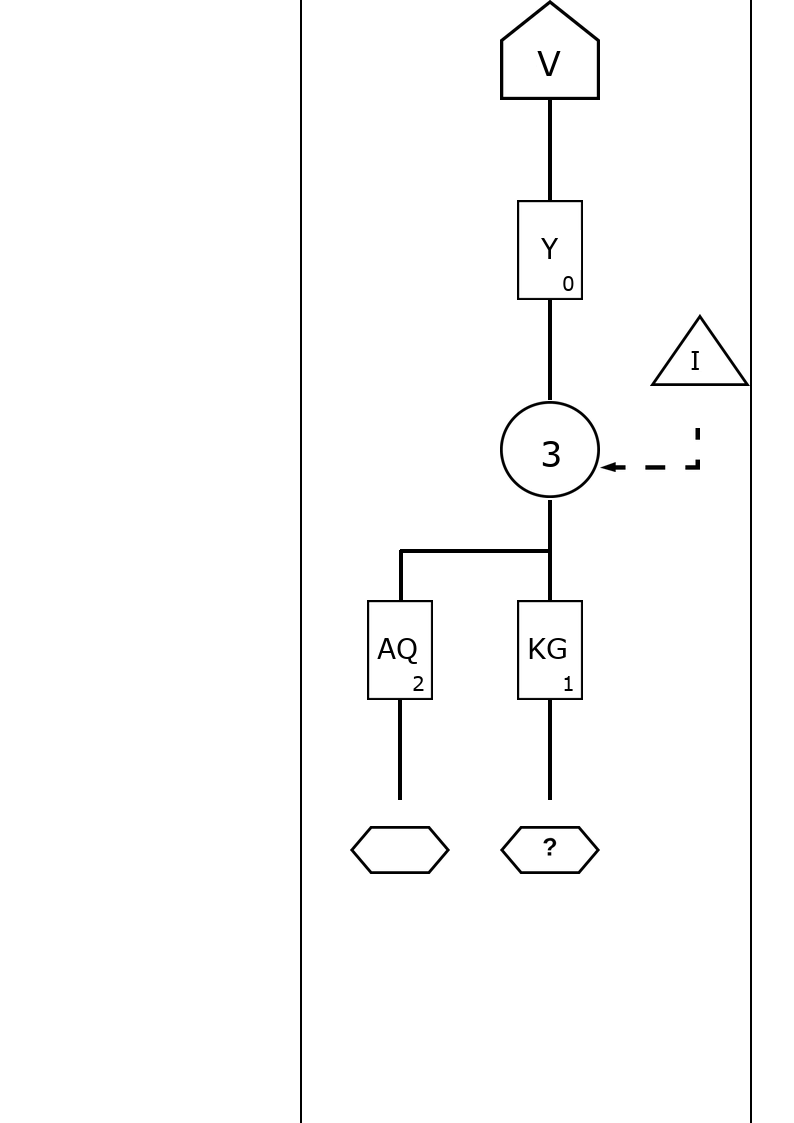

In [15]:
#@title Procesa la imagen del Docente para generar la referencia
print("> procesando diagrama docente ", imagen_docente, ": ")

if muestraDetalleDebug:
  tiempoInicioProcesarDocente = time.time()

 # carga la imagen a procesar
fn_imagen_docente = evaluar_dir_path + '/Docente/' + imagen_docente
imageCargada_doc, im_width_doc, im_height_doc = cargarImagenProcesar(fn_imagen_docente) 

if muestraDetalleDebug:
  print(" \n - Luego de cargar imagen Docente lleva ", (time.time() - tiempoInicioProcesarDocente), "segundos ")

# procesa la imagen
list_objDet_doc = obtener_objetos_imagen(imageCargada_doc, minProbObjDet, muestraDetalleObjDetectadosEnImagen)

# muestra los resultados
if muestraDetalleDebug:
  print(" \n - Luego de obtener objetos Docente con OCR lleva ", (time.time() - tiempoInicioProcesarDocente), "segundos ")

# Si no se muestran los objetos dtectados, muestra la imagen de referencia
if not(muestraDetalleObjDetectadosEnImagen):
  display( imageCargada_doc )

# ordena y organiza por área a los objetos detectados
# para la imagen de docente y arma lista para comparación
## list_objDet_doc_org => lista de objetos detectados y organizados en la imagen docente
## lista_areasX_doc_org => lista de áreas X en la imagen docente
## ppal_areaX_doc_org => ID principal área X docente
list_objDet_doc_org, lista_areasX_doc_org, ppal_areaX_doc_org = organizar_objDet(list_objDet_doc, im_width_doc, im_height_doc)

if muestraDetalleDebug:
  print(" \n - Luego de organizar áreas y objetos Docente lleva ", (time.time() - tiempoInicioProcesarDocente), "segundos ")




> procesando diagrama alumno  curso_alumno_01.png : 




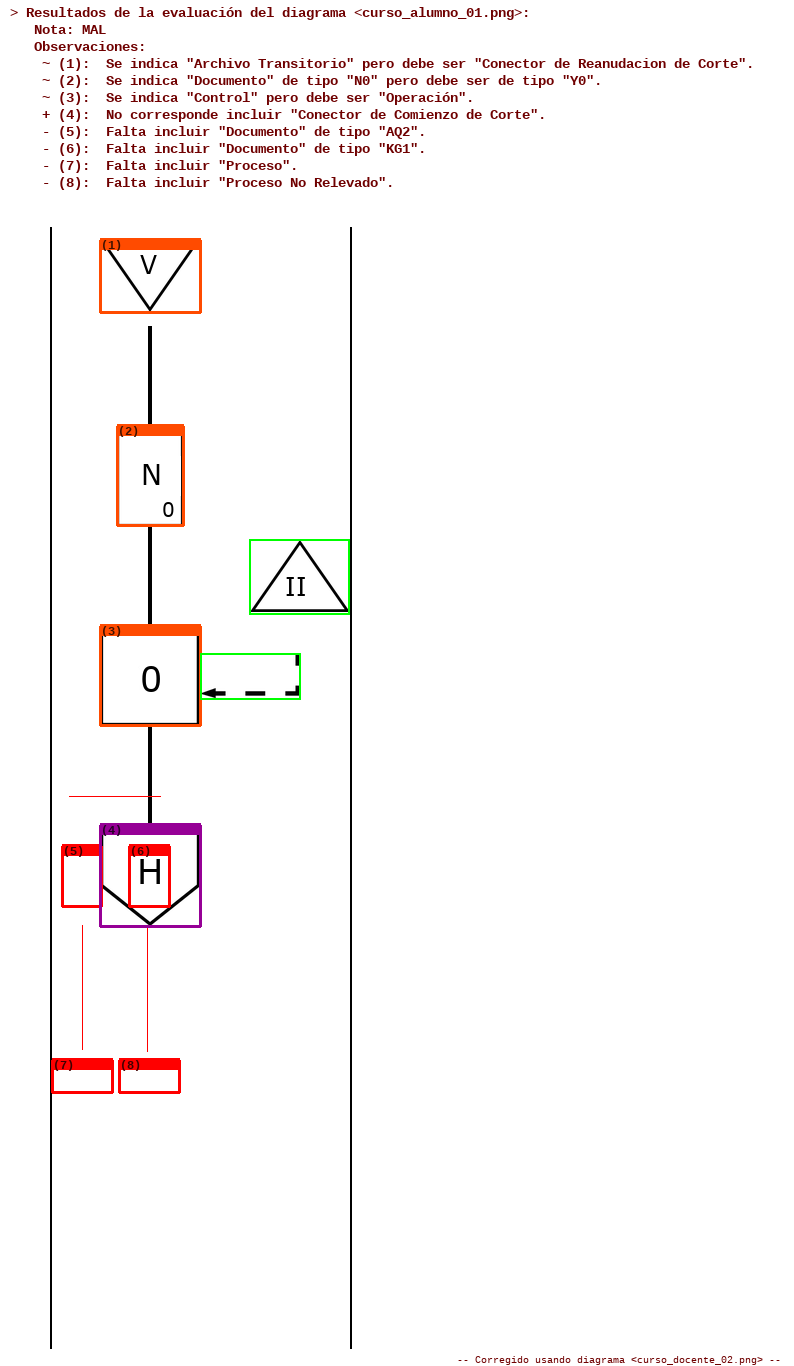



> procesando diagrama alumno  curso_alumno_02.png : 




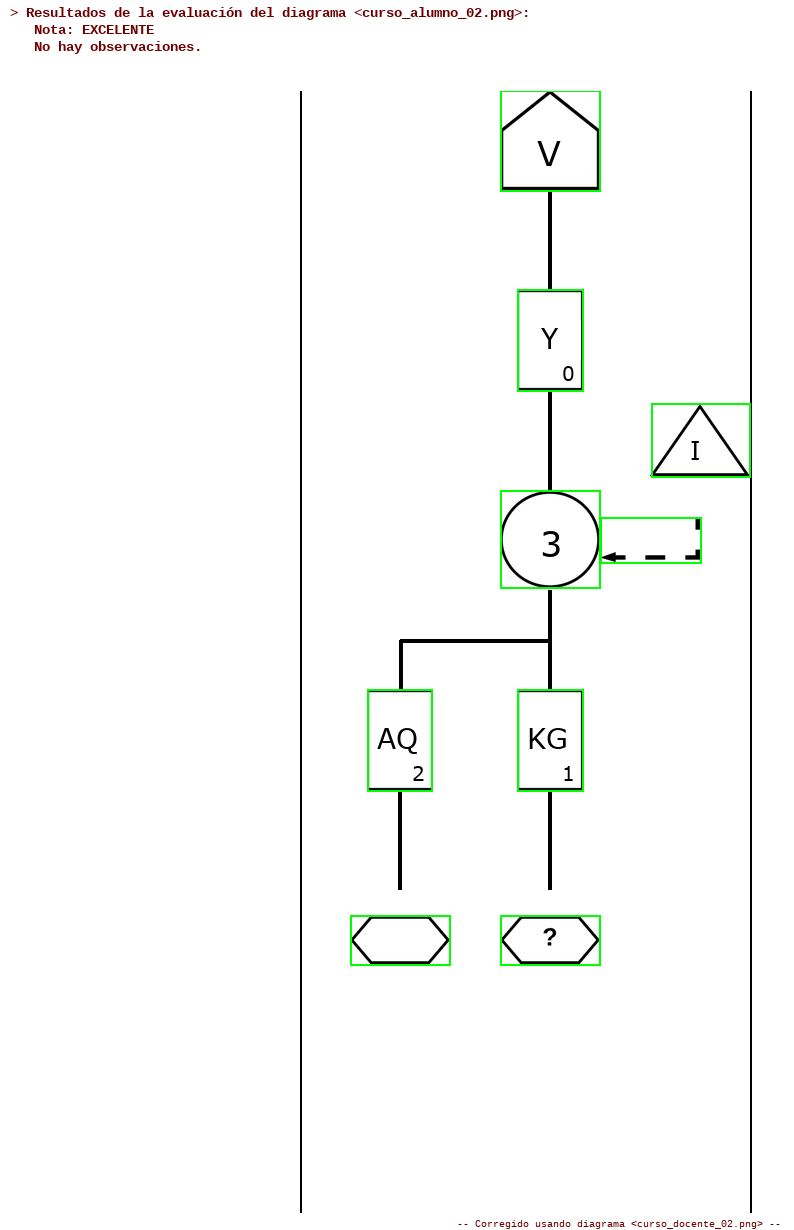



> procesando diagrama alumno  curso_alumno_03.png : 




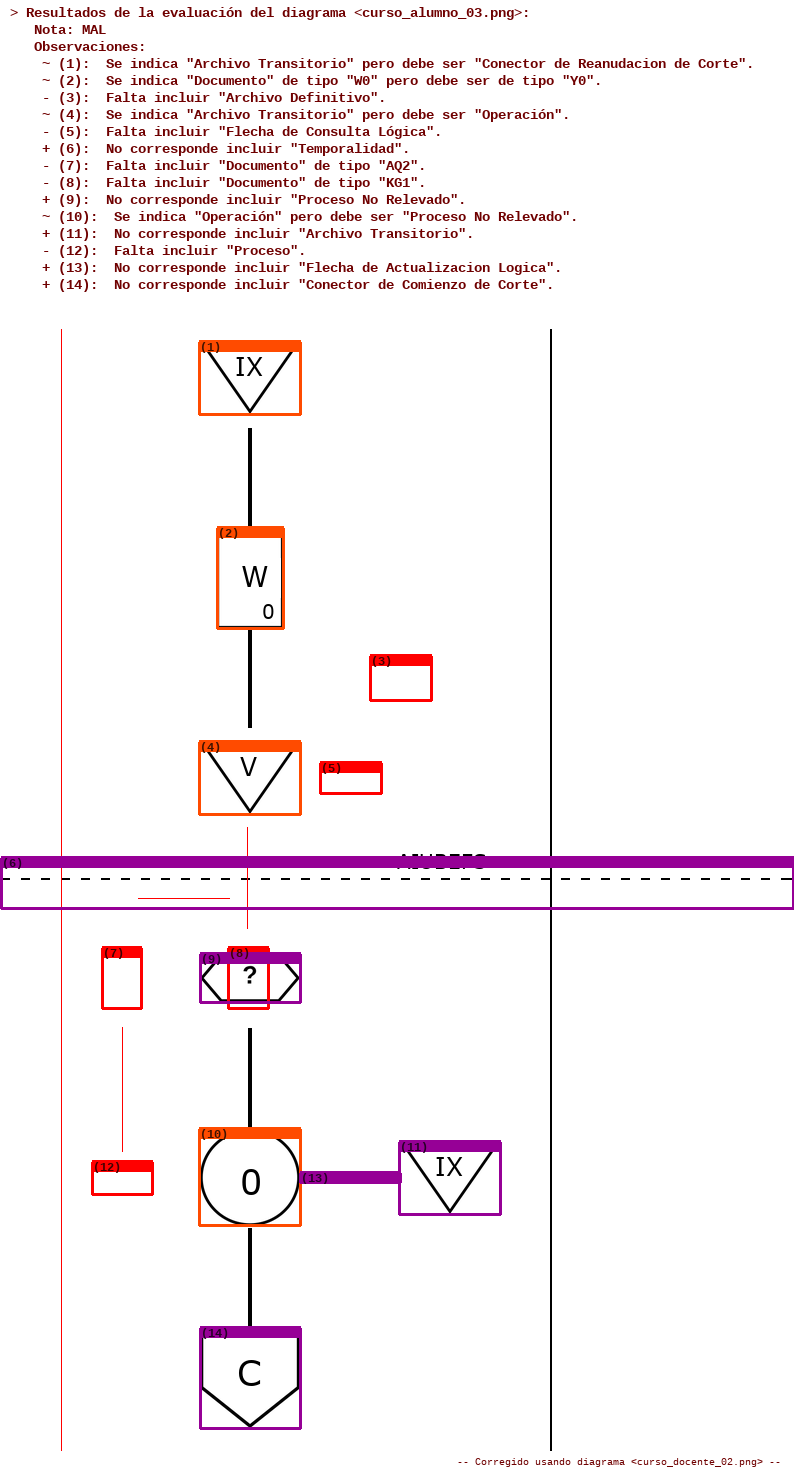



> procesando diagrama alumno  curso_alumno_04.png : 




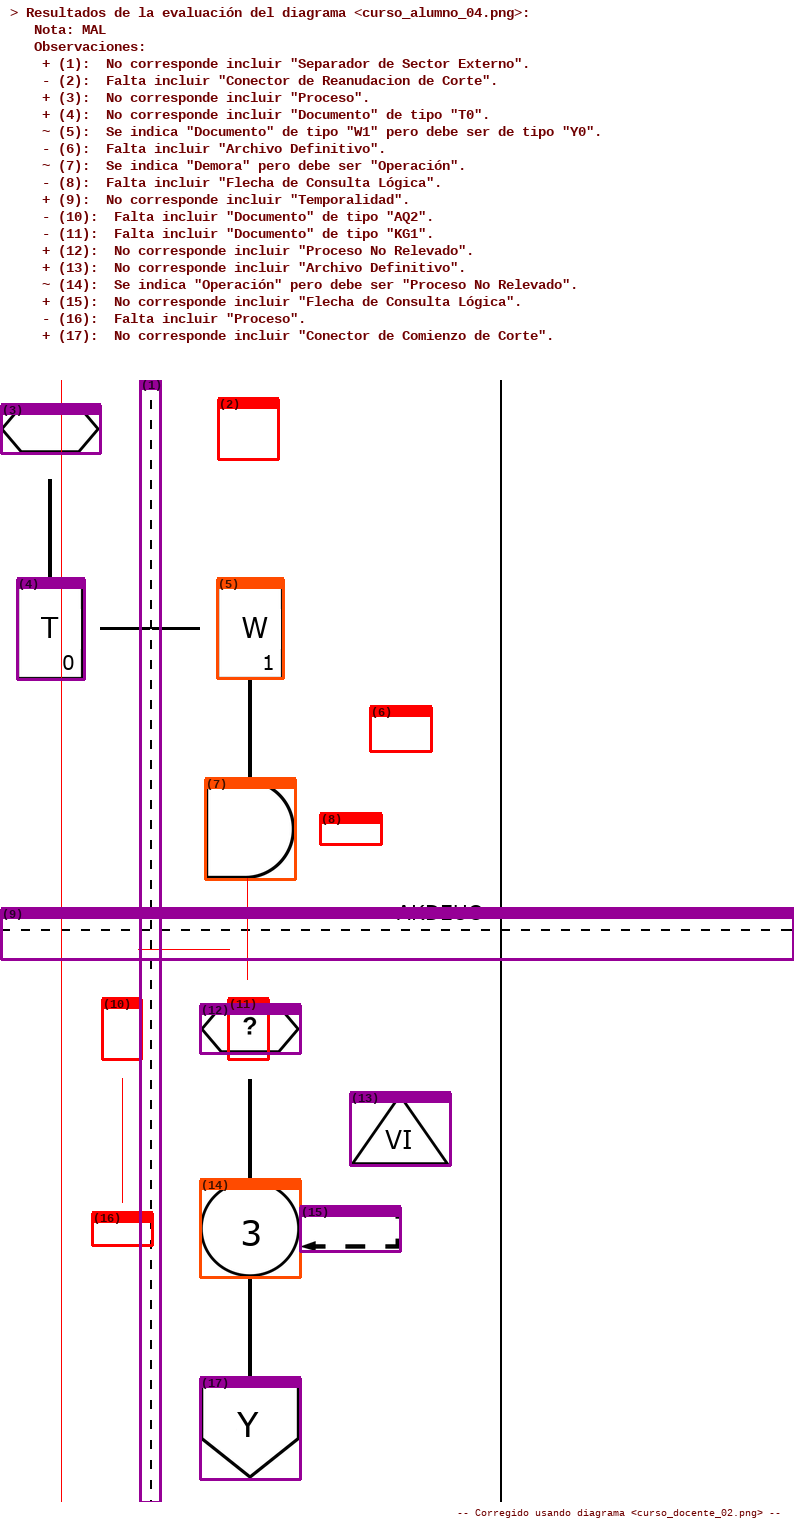



> procesando diagrama alumno  curso_alumno_05.png : 




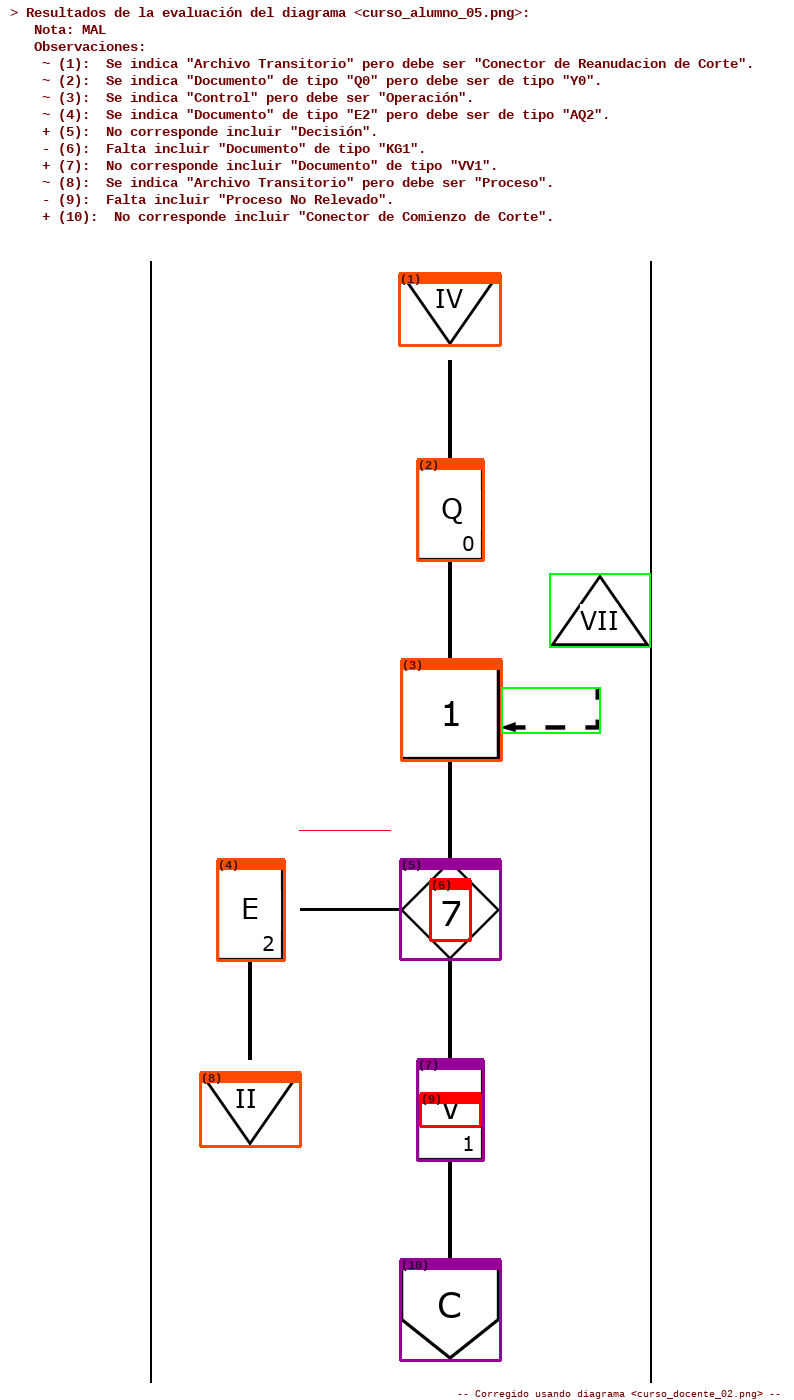



> procesando diagrama alumno  curso_alumno_06.png : 




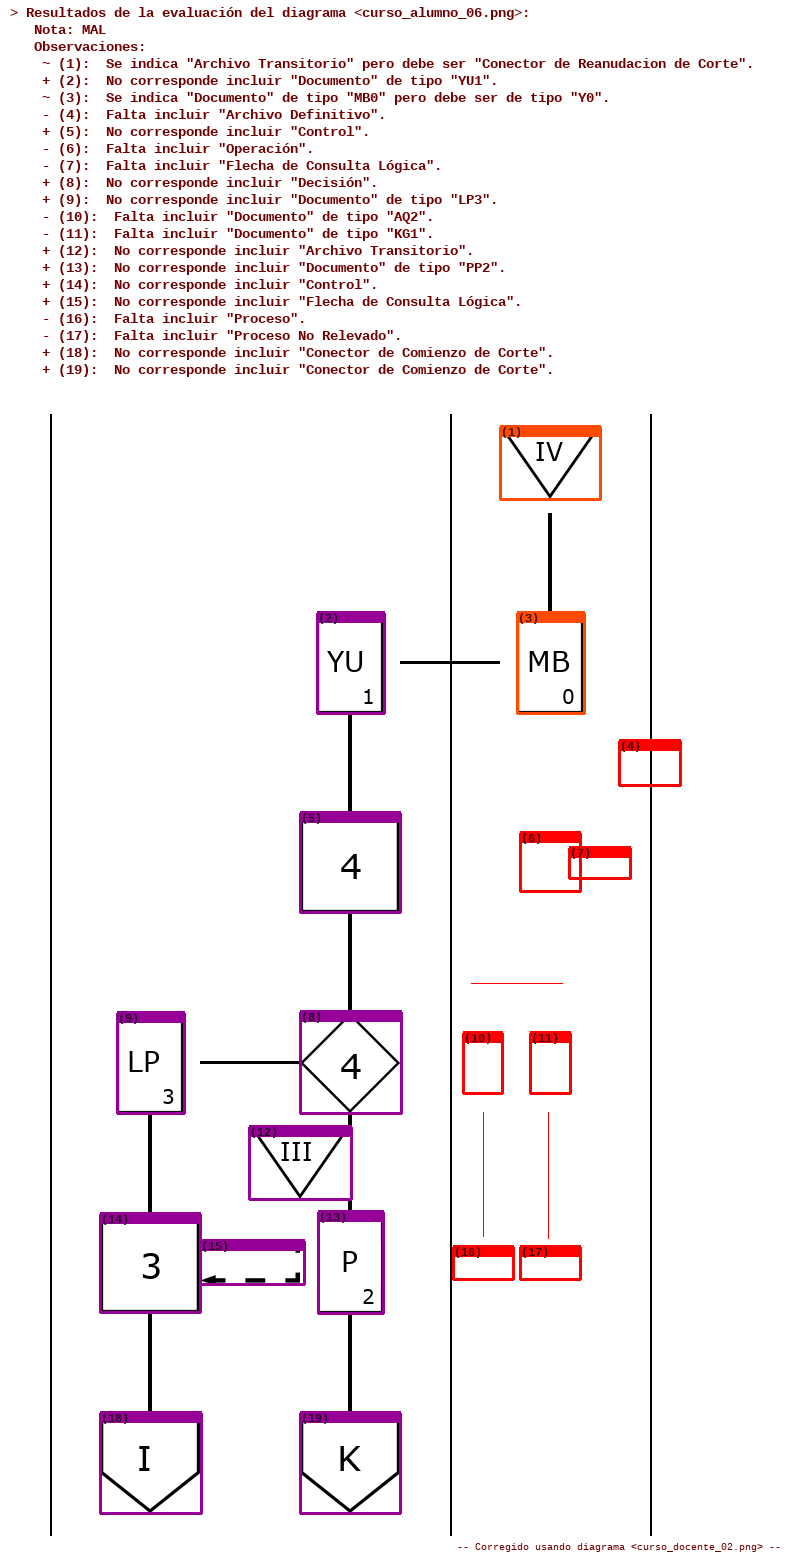



> procesando diagrama alumno  curso_alumno_07.png : 




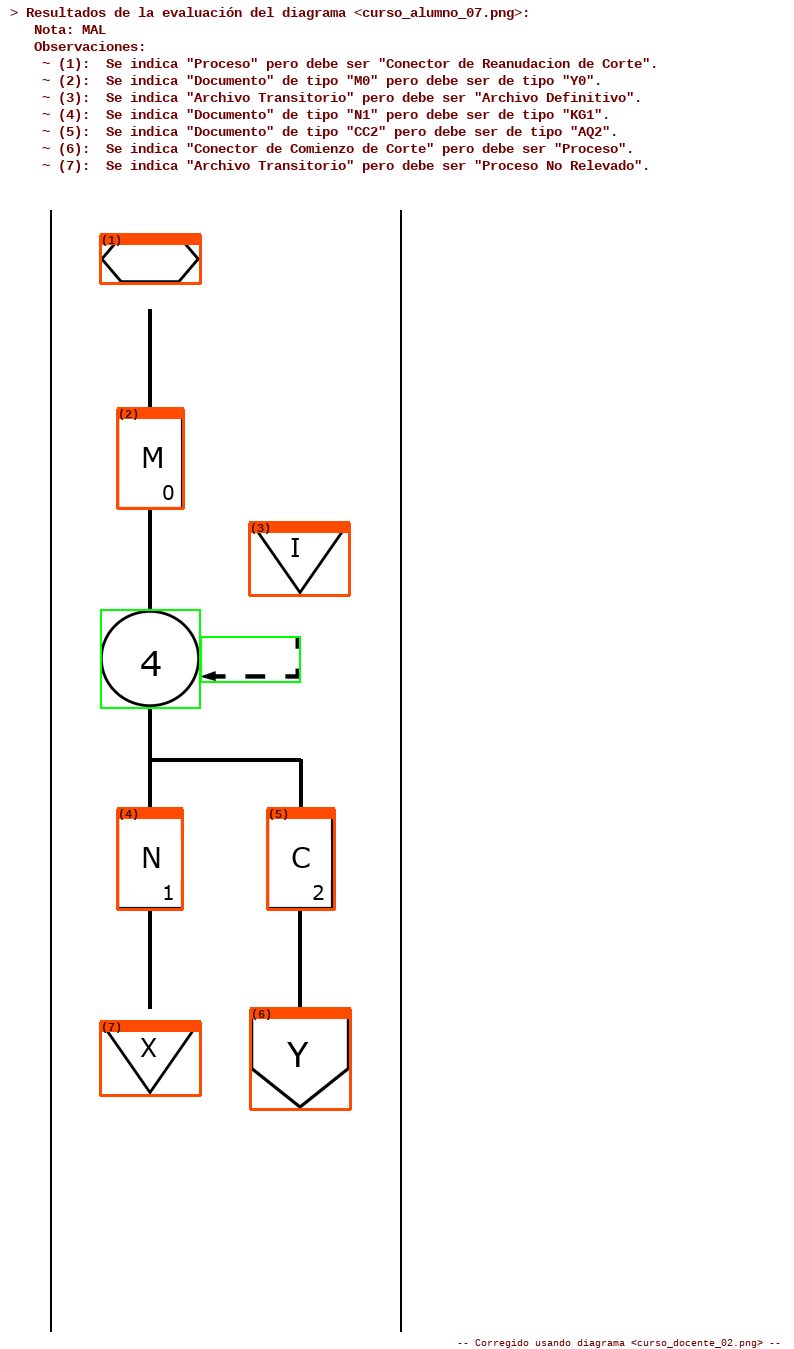



> procesando diagrama alumno  curso_alumno_11.png : 




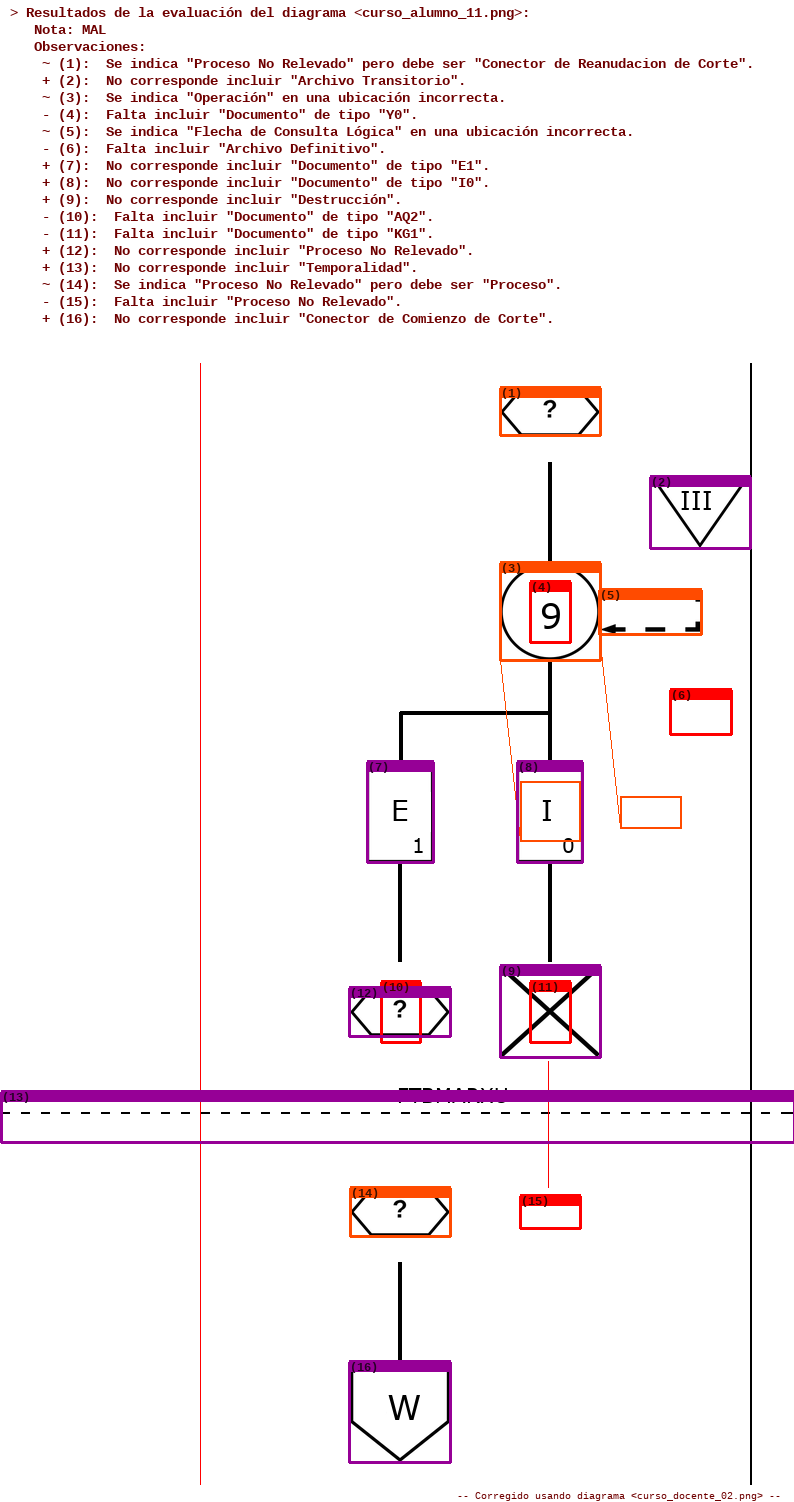



> procesando diagrama alumno  curso_alumno_12.png : 




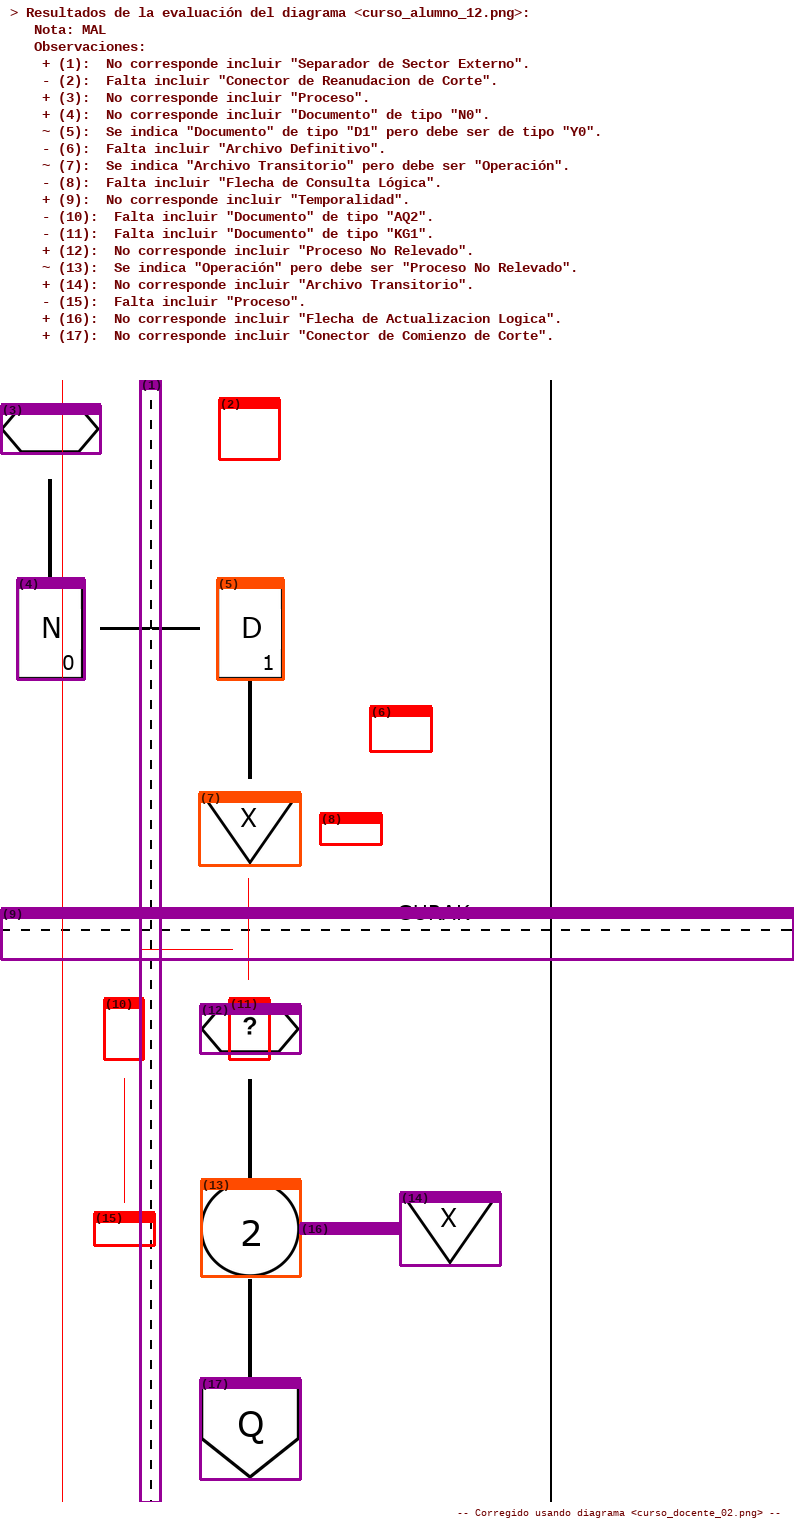



> procesando diagrama alumno  curso_alumno_13.png : 




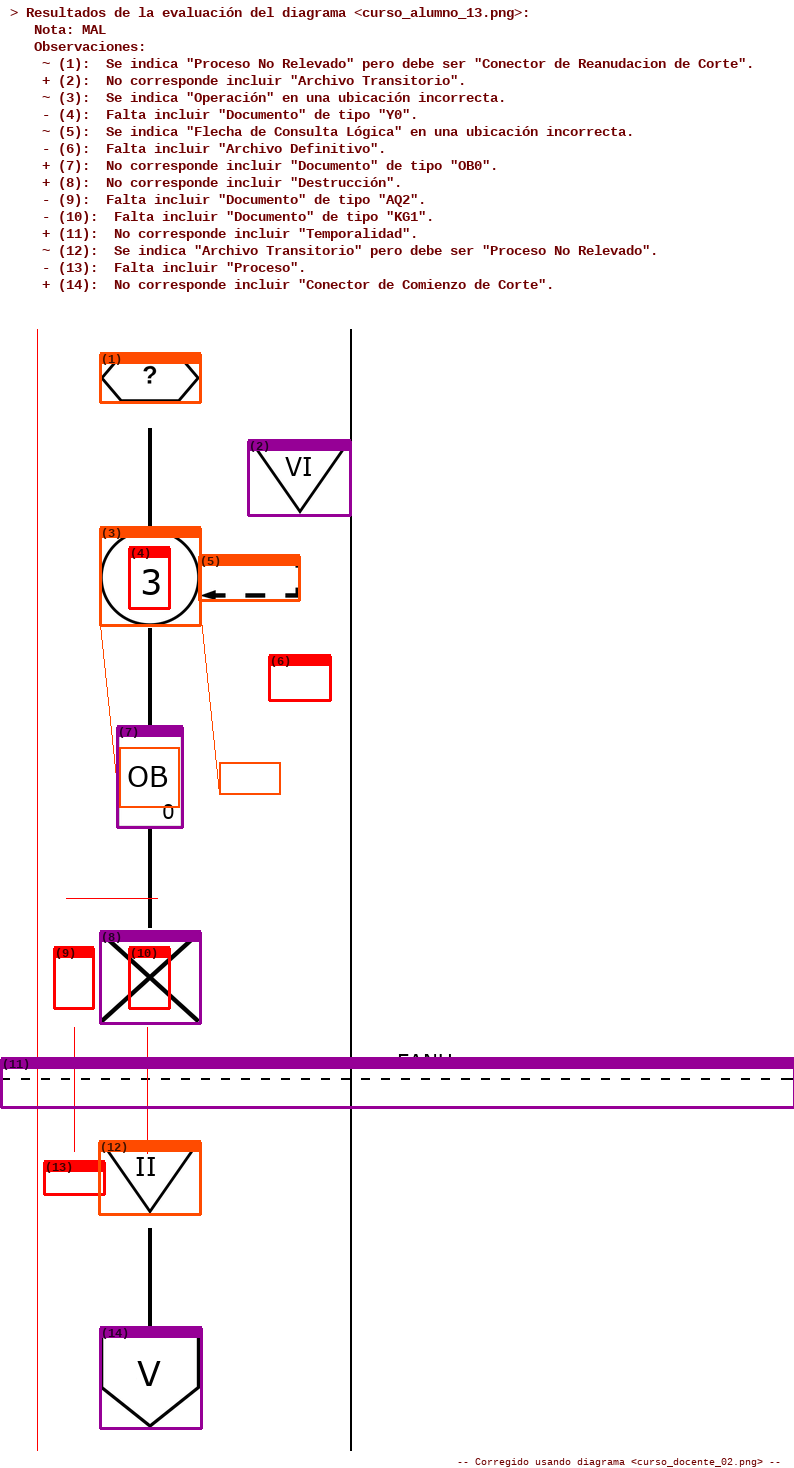

In [16]:
#@title Procesa las imágenes de Alumno para realizar la Evaluación  

# chequea que tenga la información de la imagen Docente
if list_objDet_doc_org==None or list_objDet_doc_org==[]:
  print("No se posee información de la imagen Docente de referencia!")
  exit 

# variables auxiliares de posiciones de métricas
posVP = 0
posFP_i = 1
posFP_r = 2
posFN = 3

# procesa las imágenes Alumno
for imagen_alumno in lista_imagen_alumno:

  print("\n\n> procesando diagrama alumno ", imagen_alumno, ": ")

  if muestraDetalleDebug:
    tiempoInicioProcesarAlumno = time.time()

  # carga la imagen a procesar
  fn_imagen_alumno = evaluar_dir_path + '/' + imagen_alumno
  imageCargada_al, im_width, im_height = cargarImagenProcesar(fn_imagen_alumno) 

  if muestraDetalleDebug:
    print(" \n -T- Luego de cargar imagen lleva ", (time.time() - tiempoInicioProcesarAlumno), "segundos ")

  # procesa la imagen
  list_objDet_al = obtener_objetos_imagen(imageCargada_al, minProbObjDet, muestraDetalleObjDetectadosEnImagen)

  if muestraDetalleDebug:
    print(" \n -T- Luego de obtener objetos con OCR de la lleva ", (time.time() - tiempoInicioProcesarAlumno), "segundos ")

  # ordena y organiza por área a los objetos detectados
  # para la imagen de alumno 
  ## list_objDet_al_org => lista de objetos detectados y organizados en la imagen alumno
  ## lista_areasX_al_org => lista de áreas X en la imagen alumno
  ## ppal_areaX_al_org => ID principal área X alumno
  list_objDet_al_org, lista_areasX_al_org, ppal_areaX_al_org = organizar_objDet(list_objDet_al, im_width, im_height)
  
  if muestraDetalleDebug:
    print(" \n -T- Luego de organizar áreas y objetos lleva ", (time.time() - tiempoInicioProcesarAlumno), "segundos ")

  # vector auxiliar para mostrar las metricas
  metricasImag = [ 0, 0, 0, 0]
  resObservaciones = []
  
  # imagen auxiliar para mostrar resultados comparación
  ##comp_image_pil = copy.deepcopy(imageCargada_al.convert("RGB"))
  comp_image_pil = imageCargada_al.convert("RGB")
  comp_draw = ImageDraw.Draw(comp_image_pil)

  # obtiene mapeo de áreas docente con áreas alumno para poder realizar  la comparación 
  mapeoAreasX = generarMapeoAreasX(lista_areasX_al_org, ppal_areaX_al_org, lista_areasX_doc_org, ppal_areaX_doc_org, im_width)
  
  # variables auxiliares para determinar posición Y
  ultPosBox = [0, 0, 0, 0]
  ultPosYAreaX = []
  for i in range(len(lista_areasX_doc_org)):
    ultPosYAreaX.append( 0 )
  auxCambioAreaYCompara = 0

  # variable auxiliar con símbolos alumnos pendientes asociar
  lista_IdsObj_al_proc = []
  for pos in range(len(list_objDet_al_org)):
      lista_IdsObj_al_proc.append( pos )   

  # realiza la comparación considerando los objetos de ambas imágenes
  # tratando de evaluar los iguale, los que difieren,  sobrantes o faltantes
  if muestraDetalleDebug:
    print("\n> Realiza  la comparación: ")   
    print("  Imagen Docente: cant. símbolos: ", len(list_objDet_doc_org), " - cant. áreas X: ", len(lista_areasX_doc_org))
    print("  Imagen Alumno: cant. símbolos: ", len(list_objDet_al_org), " - cant. áreas X: ", len(lista_areasX_al_org))
    print("  Mapeo AreasX Doc [", ppal_areaX_doc_org,"] <> Al [", ppal_areaX_al_org,"] : ", mapeoAreasX)

  # procesa la lista de docente primero tratando de asociar por misma clase o área
  for objDoc in list_objDet_doc_org:
      if muestraDetalleDebug: 
          print("   # procesando objDoc ", objDoc, ":")
      # determina la última posición Y 
      if (objDoc[1][0]>=0) and (objDoc[1][0]<len(ultPosYAreaX)):
        # si corresponde a un área definida, usar la correspondiente
        ultPosBox[3] = ultPosYAreaX[objDoc[1][0]]
        ultPosBox[1] = ultPosYAreaX[objDoc[1][0]]
      else:
        # sino usa la ultima más un ajuste
        ultPosBox[3] = ultPosBox[3] + 20
        ultPosBox[1] = ultPosBox[3]     
      # determina la posición que le correspondería al objeto docente en la imagen alumno      
      newPosObjDoc_ori = determinaPosicionCorrectaDocAl(rangeObj=objDoc[3], ultPosY=ultPosBox[3], 
                                                    idAreaXDoc=objDoc[1][0], doc_mapaAreasX=mapeoAreasX, 
                                                    muestraDetalleDebug=muestraDetalleDebug)
      if muestraPosicionObjetoDocenteEnImagenAlumno:
          # muestra la ubicación que correspondería en la imagen Alumno
          draw_box(comp_draw, newPosObjDoc_ori, 1, (100,100,100))           
      # evalua los simbolos alumnos con problemas
      noEncAlumno = True
      for pos_al in lista_IdsObj_al_proc:
          # vuelve a tomar la nueva posición original (sin ajuste de eje)
          newPosObjDoc = newPosObjDoc_ori
          # carga el símbolo alumno a procesar
          objAl = list_objDet_al_org[pos_al]
          # calcula IoU con respecto al objeto Alumno
          ##IoUnDocAl = calc_IoU(newPosObjDoc, objAl[3])    
          # analiza si coincde posición objeto docente con respecto al objeto Alumno
          # y sino trata de ajustarlo un poco en eje X o Y para que coincida
          resnDocAl, newPosObjDoc = podriaCoincidirPos(newPosObjDoc, objAl[3], coefIoU, muestraDetalleDebug)                
          # evalúa                       
          if objAl[2] == objDoc[2]:               
              # si tiene igual clase ...
              if resnDocAl:
                  # ... y misma ubicación (considerando IoU entre objetos Doc y Al) 
                  if objAl[4] == objDoc[4]:    
                      # .... y mismo textoOCR
                      if muestraDetalleDebug: 
                        print("       =  se rectifica con objAl ",  objAl)
                        print("             resnDocAl: ", resnDocAl, "& coefIoU: ", coefIoU, "& ultPosBox: ", ultPosBox, "& auxCambioAreaYCompara: ", auxCambioAreaYCompara)     
                      # actualiza imagen y última posición Y
                      ultPosBox  = procesar_compara_igual( objAl )
                      noEncAlumno = False
                  else:
                      # .... pero distinto textoOCR
                      newPosObjDoc = newPosObjDoc_ori
                      if muestraDetalleDebug: 
                        print("       ~  se encuentra igual clase y misma ubicación, pero distinto textoOCR con objAl ",  objAl)
                        print("             resnDocAl: ", resnDocAl, "& coefIoU: ", coefIoU, "& ultPosBox: ", ultPosBox, "& auxCambioAreaYCompara: ", auxCambioAreaYCompara)   
                      # actualiza imagen y última posición Y
                      ultPosBox = procesar_compara_distTextoOCR(objDoc, objAl)              
                      noEncAlumno = False
              else:
                  # ... y distinta ubicación
                  distObjDocAl = ( abs(newPosObjDoc[0]-objAl[3][0]) + abs(newPosObjDoc[1]-objAl[3][1]) )
                  if (distObjDocAl < max_dif_permitida_asociar_mismoClase_difPos):
                  # pero no demasiado lejos              
                    if objAl[4] == objDoc[4]:    
                    # .... pero mismo textoOCR                  
                      if (objAl[1][1] + auxCambioAreaYCompara) <= objDoc[1][1]:
                        # ... pero respetando el área Y para que no se demasiado diferente
                        if muestraDetalleDebug: 
                          print("       ~  se encuentra igual clase & textoOCR, pero distinta ubicación con objAl ",  objAl)
                          print("             resnDocAl: ", resnDocAl, "& distObjDocAl: ", distObjDocAl,"& coefIoU: ", coefIoU, "& ultPosBox: ", ultPosBox, "& auxCambioAreaYCompara: ", auxCambioAreaYCompara)   
                        # actualiza imagen y última posición Y
                        ultPosBox = procesar_compara_distArea(objDoc, newPosObjDoc, objAl)              
                        noEncAlumno = False
          else:
              # si tiene distinta clase, pero son del mismo "claseAgrupa" ...
              # nota acá no evalua el textoOCR porque si la clase es distinta puede diferir
              if (config_simbolos[objDoc[2]][config_posClaseAgrupa] == config_simbolos[objAl[2]][config_posClaseAgrupa]):
                # compara la posición en la que debería estar el objeto Docente con el objeto en Alumno
                #if (IoUnDocAl >= coefIoU):
                if resnDocAl:
                    # ... y mismas misma ubicación (considerando IoU entre objetos Doc y Al) 
                    if muestraDetalleDebug: 
                      print("       ~  se encuentra distinta clase, pero misma ubicación: con objAl ",  objAl)
                      print("             resnDocAl: ", resnDocAl, "& coefIoU: ", coefIoU, "& ultPosBox: ", ultPosBox, "& auxCambioAreaYCompara: ", auxCambioAreaYCompara)  
                    # actualiza imagen y última posición Y
                    ultPosBox = procesar_compara_distClase(objDoc, objAl) 
                    noEncAlumno = False        
          
          if not(noEncAlumno):      
            # saca de la lista auxiliar de alumno porque ya se utilizó
            lista_IdsObj_al_proc.remove( pos_al )           
            # sale del loop del for porque no tiene sentido seguir evaluando
            break
        
      if noEncAlumno:
          # si no se encontró, quiere decir que falta en Alumno
          # registra en imagen
          # vuelve a tomar la nueva posición original (sin ajuste de eje)
          if muestraDetalleDebug: 
              print("       -  no se encuentra doc: ", objDoc)
              print("             ultPosBox: ", ultPosBox, "& auxCambioAreaYCompara: ", auxCambioAreaYCompara) 
          # actualiza imagen y última posición Y
          ultPosBox = procesar_compara_falta(objDoc, newPosObjDoc_ori)    
          if config_simbolos[objDoc[2]][config_posTipoCambiarAreaY]>0:
              # si es un objeto que produce cambio de area Y
              auxCambioAreaYCompara = auxCambioAreaYCompara + 100    
      
      # si había encontrado o no al objeto, procede a actualizar la última posición Y 
      if (objDoc[1][0] < 0): 
        # si el área X es menor que cero 
        # fuerza un ajuse de la última pos Y (por espacio dejado)
        ultPosBox[1] = ultPosBox[3] + 10      
      # si no es un cambio de sector
      if config_simbolos[objDoc[2]][config_posTipoCambiarAreaX] < 100:
        # ajusta la última pos Y (si es menor)
        # -> misma área X = posición de abajo, sino posición de arriba
        for i in range(len(ultPosYAreaX)):
            if i==objDoc[1][0]:
              if ultPosYAreaX[i] < ultPosBox[3]:
                ultPosYAreaX[i] = ultPosBox[3]
            else:
              if ultPosYAreaX[i] < ultPosBox[1]:
                ultPosYAreaX[i] = ultPosBox[1]      
        if muestraDetalleDebug: 
          print("             actualiza nultPosBox ", ultPosBox," -> ultPosYAreaX: ", ultPosYAreaX)              
              
  # luego de procesar todos los objetos docentes, 
  # todos los que queden en la  lista de alumnos se toman como sobrantes
  for posA in lista_IdsObj_al_proc:
      # carga el símbolo alumno a procesar
      objAl = list_objDet_al_org[posA]     
      # si no se ignora
      if config_simbolos[objAl[2]][config_posEvalua]:
          # registra en la imagen 
          if muestraDetalleDebug: 
              print("       +  sobra al: ", objAl)
          # actualiza imagen y última posición Y
          ultPosBox =  procesar_compara_sobra( objAl )           

  if muestraDetalleDebug:  
    print(" \n -T- Luego de comparar objetos lleva ", (time.time() - tiempoInicioProcesarAlumno), "segundos ")

  # genera el texto para el encabezado
  textoHeader = []
  textoHeader.append( agregarTituloEvalucion(imagen_alumno) )
  
  # Cálcula y devuelve la nota del cursograma
  textoHeader.append( calcularNotaAlumno() )

  # Genera y devuelve las observaciones
  textoHeader.extend( generarObservaciones() )
 
  print("\n")
  if (muestraDetalleComparacionEnImagen == "Todas") or (metricasImag[posFP] > 0) or (metricasImag[posFN] > 0):

          # agrega el texto de la cabecera a la imagen
          comp_image_pil, comp_draw = draw_image_new_header(comp_image_pil, comp_draw, textoHeader)

          # muestra la imagen con los resultados de la comparación
          display( comp_image_pil )

          # guarda y/o baja la imagen con las correcciones marcadas
          # por el evaluado automaticamente
          if guardarEnDriveImagenesAlumnoEvaluadas or bajarAutomaticamenteImagenesAlumnoEvaluadas:
            nomArchi = "Eval_curso_doc_" + imagen_docente[14:16] + "_al_" + imagen_alumno[13:15] + ".png" 
            comp_image_pil.save(evaluar_dir_path_resultados + nomArchi)
            if bajarAutomaticamenteImagenesAlumnoEvaluadas:
                try: 
                  files.download(evaluar_dir_path_resultados + nomArchi)
                  print('Imagen ' + nomArchi + ' generada, debería bajarse automaticamente como un archivo local...')
                except ValueError:
                  print('Error al intentar descargar el archivo ' + nomArchi)

  else:
          # muestra el texto de la cabecera          
          for txt in textoHeader:
              print( txt )
          print("\n")

  if muestraDetalleMetricasComparacion:        
      mostrarMetricas(imagen_alumno)

  if muestraDetalleDebug:
    print(" \n -T- Procesamiento total de la imagen lleva ", (time.time() - tiempoInicioProcesarAlumno), "segundos ")
